In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Loading dataset

In [30]:
!nvidia-smi

Sat Jul  9 17:44:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   1517MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2) Importing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install ray[tune]

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

In [33]:
aggressions = load_dataset('csv', data_files={'train': 'Combined_DS.csv'
                                              })

Using custom data configuration default-70054110123fb2ae
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-70054110123fb2ae/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
print(aggressions)

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Category'],
        num_rows: 14663
    })
})


## 3) Converting to dataframe

In [34]:
aggressions.set_format(type='pandas')
df = aggressions['train'][:]
df.head()

,Sentence,Category
0,This old man has nothing in his mind. He doesn...,CAG
1,"Congratulations Bmp & Modiji, Please do someth...",CAG
2,Excellent! So what's his plan ? Relocating to ...,CAG
3,Please forgive us Modi. We cant take more juml...,CAG
4,"In India, one can utter anything against Islam...",OAG


In [35]:
# Shuffling datafram samples

shuffled_df = df.sample(frac=1, random_state=1).reset_index()
shuffled_df.head()

,index,Sentence,Category
0,12705,"Kabir singh = succesfull man, ambitious man wi...",NAG
1,11371,Growth without inclusiveness is only a myth,NAG
2,9213,Those who are against demonization may be illi...,CAG
3,1113,what he said is 100% true,CAG
4,3011,hero!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,NAG


In [36]:
shuffled_df['Category'].value_counts()

NAG    6595
CAG    4758
OAG    3310
Name: Category, dtype: int64

In [37]:
# Label encoding
dt = {'NAG':0, 'CAG':1, 'OAG':2}
shuffled_df['Category'].unique()
labels = map(lambda x: dt[x], shuffled_df['Category'])
labels = list(labels)
labels = pd.Series(labels)

shuffled_df['Label'] = labels
labs = np.array(labels)
shuffled_df.head(5)

,index,Sentence,Category,Label
0,12705,"Kabir singh = succesfull man, ambitious man wi...",NAG,0
1,11371,Growth without inclusiveness is only a myth,NAG,0
2,9213,Those who are against demonization may be illi...,CAG,1
3,1113,what he said is 100% true,CAG,1
4,3011,hero!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,NAG,0


Seeing Distribution

In [10]:
disb_df = shuffled_df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


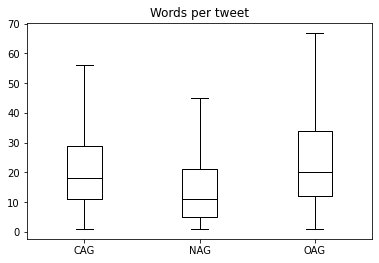

In [11]:
disb_df['Words per tweet'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per tweet', by='Category', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [38]:
from transformers import AutoTokenizer

In [39]:
model_ckpt = 'l3cube-pune/hing-bert'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

loading file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/019fdf4dbdbe2f7d275edbd8357a371dcf78d93e4fd8b3b75c06ba93b4736ba4.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/bcf22afd2528bce7cce811af17dc33d7df31f6bfac49e56964857c673fc77daf.f71e12dcf3314f964e59f54247509b88c99b9eac702db689a9c4bd9444c88904
loading file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/d779bf75d9255ddee241d6981908ad4821a70c6ac1308468f6d0ea488775c78c.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/tokenizer_con

In [19]:
tokenizer.vocab_size

30522

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
texts = list(shuffled_df['Sentence'])
labels = list(shuffled_df['Label'])

## 5) Splitting into train-valid-test

In [42]:
train_size=0.8

# In the first step we will split the data in training and remaining dataset
train_texts, X_rem, train_labels, y_rem = train_test_split(texts, labels, train_size=0.8, random_state=43)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
valid_texts, test_texts, valid_labels, test_labels = train_test_split(X_rem, y_rem, test_size=0.5, random_state=43)

print(str(np.shape(train_texts))), print(str(np.shape(train_labels)))
print(str(np.shape(valid_texts))), print(str(np.shape(valid_labels)))
print(str(np.shape(test_texts))), print(str(np.shape(test_labels)))


(11730,)
(11730,)
(1466,)
(1466,)
(1467,)
(1467,)


(None, None)

In [43]:
# USE this only for hyperparameter tuning
# In this step we will split the train data (15 %) and validation data (20%) only for hyperparameter tuning 


_texts, hyp_texts, _labels, hyp_labels = train_test_split(train_texts, train_labels, test_size=0.15, random_state=43)
print(str(np.shape(hyp_texts))), print(str(np.shape(hyp_labels)))

_texts2, hyp_v_texts, _labels2, hyp_v_labels = train_test_split(valid_texts, valid_labels, test_size=0.2, random_state=43)
print(str(np.shape(hyp_v_texts))), print(str(np.shape(hyp_v_labels)))

(1760,)
(1760,)
(294,)
(294,)


(None, None)

In [44]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)
hyp_encodings = tokenizer(hyp_texts, truncation=True, padding=True)
hyp_v_encodings = tokenizer(hyp_v_texts, truncation=True, padding=True)

In [45]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [46]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)
hyp_dataset = AggressionDataset(hyp_encodings, hyp_labels)
hyp_v_dataset = AggressionDataset(hyp_v_encodings, hyp_v_labels)

## 6) Fine-tuning

In [47]:
import torch

In [47]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [27]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if 
                      torch.cuda.is_available() else 'cpu')
print(device)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

cuda


Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hing-bert a

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [29]:
from transformers import Trainer, TrainingArguments

In [32]:
# Defining hyperparameters
batch_size = 16
logging_steps = len(train_texts) // batch_size
model_name = f"{model_ckpt}-finetuned-aggression"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True,
                                  log_level='error')

In [34]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [48]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.32, 0.47]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [36]:
trainer = CustomTrainer(model=model, args=training_args,
compute_metrics = compute_metrics,
train_dataset = train_dataset,
eval_dataset = valid_dataset,
tokenizer = tokenizer)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.319400,1.042404,0.708049,0.683053,0.685355,0.684088
2,0.158000,1.477938,0.689632,0.664315,0.672428,0.666963
3,0.120800,1.766641,0.685539,0.660004,0.664851,0.661820


TrainOutput(global_step=2202, training_loss=0.199325192756917, metrics={'train_runtime': 1919.5015, 'train_samples_per_second': 18.333, 'train_steps_per_second': 1.147, 'total_flos': 9258961169848320.0, 'train_loss': 0.199325192756917, 'epoch': 3.0})

## 7) Predictions and Results

In [37]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [38]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [39]:
preds_output_test = trainer.predict(test_dataset)

In [40]:
preds_output_test.metrics

{'test_accuracy': 0.6816632583503749,
 'test_f1': 0.6593418811518305,
 'test_loss': 1.8565630912780762,
 'test_precision': 0.6589107205944329,
 'test_recall': 0.6598463463798515,
 'test_runtime': 25.1619,
 'test_samples_per_second': 58.302,
 'test_steps_per_second': 3.656}

In [41]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [42]:
y_valid_test = np.array(test_dataset.labels)

In [43]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [44]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.81      0.81      0.81       630
         CAG       0.60      0.59      0.59       485
         OAG       0.57      0.58      0.58       352

    accuracy                           0.68      1467
   macro avg       0.66      0.66      0.66      1467
weighted avg       0.68      0.68      0.68      1467



In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

cm = confusion_matrix(y_valid_test, y_preds_test)

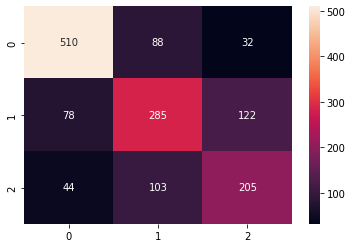

In [46]:
f = sns.heatmap(cm, annot=True, fmt='d')

## 8) Using hyperparameter tuning with ray tune

In [49]:
from ray.tune.schedulers import PopulationBasedTraining
import ray
from ray import tune
from ray.tune import CLIReporter
from transformers import Trainer, TrainingArguments

In [56]:
from transformers import AutoModelForSequenceClassification

# num_labels = 3
# device = torch.device('cuda')
# if torch.cuda.is_available() else 'cpu'
# print(device)
# model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

def get_my_model():
  num_labels = 3
  device = torch.device('cuda')
  return (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

In [57]:
from datasets import load_metric

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  metric = load_metric("f1")
  return metric.compute(predictions=preds, references=labels, average="macro")

In [58]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.31, 0.48]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [59]:
# See this for more stoppers
# https://docs.ray.io/en/latest/tune/api_docs/stoppers.html

from ray.tune import Stopper

class CustomStopper(tune.Stopper):
        def __init__(self):
            self.should_stop = False

        def __call__(self, trial_id, result):
            max_iter = 4
            if not self.should_stop and result["training_iteration"] >= max_iter:
                self.should_stop = True

        def stop_all(self):
            return self.should_stop

stopper = CustomStopper()

In [60]:
from ray.tune.examples.pbt_transformers.utils import build_compute_metrics_fn
from transformers import Trainer, TrainingArguments
# task_name = 'rte'

training_args = TrainingArguments(
        output_dir=".",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        logging_dir="./logs",
        skip_memory_metrics=True,
        report_to="none",
        # metric_for_best_model=metric_name,

    )

trainer = CustomTrainer(model_init=get_my_model, args=training_args,
        compute_metrics = compute_metrics,
        train_dataset = hyp_dataset,
        eval_dataset = hyp_v_dataset,
        tokenizer = tokenizer)

tune_config = {
        "per_device_train_batch_size": tune.choice([16, 32]),
        "per_device_eval_batch_size": 16,
        "num_train_epochs": tune.choice([3, 4, 5, 6]),
        # "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
    }

scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "learning_rate": tune.uniform(1e-5, 5e-5),
            "per_device_train_batch_size": [16, 32],
        },
    )

reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs",
        },
        metric_columns=["eval_f1", "eval_loss", "epoch", "training_iteration"],
    )


ress = trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=4,
        resources_per_trial={"cpu": 0, "gpu": 1},
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop=stopper,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        log_to_file=True,
    )

PyTorch: setting up devices
loading configuration file https://huggingface.co/l3cube-pune/hing-bert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d52c8be56cd7426f65f746f8597f9a2955921e2ad53793f8949bd8794e6372ef.ac4c51fbb6396469b4ec05f0bdf5f51204ca04692ad36e8ade986838956c1bd8
Model config BertConfig {
  "_name_or_path": "l3cube-pune/hing-bert",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "eos_token_ids": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": 

== Status ==
Current time: 2022-07-09 18:00:18 (running for 00:00:00.15)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

(_objective pid=2432) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
(_objective pid=2432) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2432) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2432) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:00:33 (running for 00:00:14.56)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  2%|▏         | 10/660 [00:08<08:55,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:00:38 (running for 00:00:19.56)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  2%|▏         | 16/660 [00:13<08:51,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:00:43 (running for 00:00:24.57)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  3%|▎         | 22/660 [00:18<08:44,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:00:48 (running for 00:00:29.58)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  4%|▍         | 28/660 [00:23<08:40,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:00:53 (running for 00:00:34.58)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  5%|▌         | 34/660 [00:28<08:35,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:00:58 (running for 00:00:39.59)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  6%|▌         | 40/660 [00:32<08:30,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:01:03 (running for 00:00:44.59)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  7%|▋         | 46/660 [00:37<08:27,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:08 (running for 00:00:49.59)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  8%|▊         | 53/660 [00:43<08:19,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:13 (running for 00:00:54.60)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

  9%|▉         | 59/660 [00:48<08:15,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:18 (running for 00:00:59.61)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 10%|▉         | 65/660 [00:53<08:09,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:23 (running for 00:01:04.61)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 11%|█         | 71/660 [00:58<08:04,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:01:28 (running for 00:01:09.62)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 12%|█▏        | 77/660 [01:03<08:00,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:33 (running for 00:01:14.62)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 13%|█▎        | 83/660 [01:08<07:55,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:38 (running for 00:01:19.63)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 13%|█▎        | 89/660 [01:13<07:49,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:01:43 (running for 00:01:24.63)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 14%|█▍        | 95/660 [01:18<07:45,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:48 (running for 00:01:29.64)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 15%|█▌        | 101/660 [01:23<07:39,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:01:53 (running for 00:01:34.64)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 16%|█▌        | 107/660 [01:28<07:36,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:01:58 (running for 00:01:39.65)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

 17%|█▋        | 110/660 [01:30<07:34,  1.21it/s]
(_objective pid=2432) 
  0%|          | 0/19 [00:00<?, ?it/s]
(_objective pid=2432) 
 11%|█         | 2/19 [00:00<00:02,  7.43it/s]
(_objective pid=2432) 
 16%|█▌        | 3/19 [00:00<00:03,  5.24it/s]
(_objective pid=2432) 
 21%|██        | 4/19 [00:00<00:03,  4.54it/s]
(_objective pid=2432) 
 26%|██▋       | 5/19 [00:01<00:03,  4.20it/s]
(_objective pid=2432) 
 32%|███▏      | 6/19 [00:01<00:03,  4.02it/s]
(_objective pid=2432) 
 37%|███▋      | 7/19 [00:01<00:03,  3.91it/s]
(_objective pid=2432) 
 42%|████▏     | 8/19 [00:01<00:02,  3.84it/s]
(_objective pid=2432) 
 47%|████▋     | 9/19 [00:02<00:02,  3.79it/s]
(_objective pid=2432) 
 53%|█████▎    | 10/19 [00:02<00:02,  3.76it/s]
(_objective pid=2432) 
 58%|█████▊    | 11/19 [00:02<00:02,  3.74it/s]


== Status ==
Current time: 2022-07-09 18:02:03 (running for 00:01:44.65)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

(_objective pid=2432) 
 63%|██████▎   | 12/19 [00:02<00:01,  3.73it/s]
(_objective pid=2432) 
 68%|██████▊   | 13/19 [00:03<00:01,  3.72it/s]
(_objective pid=2432) 
 74%|███████▎  | 14/19 [00:03<00:01,  3.71it/s]
(_objective pid=2432) 
 79%|███████▉  | 15/19 [00:03<00:01,  3.71it/s]
(_objective pid=2432) 
 84%|████████▍ | 16/19 [00:04<00:00,  3.70it/s]
(_objective pid=2432) 
 89%|████████▉ | 17/19 [00:04<00:00,  3.70it/s]
(_objective pid=2432) 
 95%|█████████▍| 18/19 [00:04<00:00,  3.70it/s]
(_objective pid=2432) 
100%|██████████| 19/19 [00:04<00:00,  4.49it/s]


(_objective pid=2432) {'eval_loss': 0.7801083922386169, 'eval_f1': 0.6091330019965168, 'eval_runtime': 5.4584, 'eval_samples_per_second': 53.862, 'eval_steps_per_second': 3.481, 'epoch': 1.0}


                                                 
100%|██████████| 19/19 [00:05<00:00,  4.49it/s]
                                               


== Status ==
Current time: 2022-07-09 18:02:08 (running for 00:01:49.66)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |            6 |
| _objective_fe20c_00001 | PENDING  |                 | 0.0468056  | 1.62398e-05 |             16 |            3 |
| _objective_fe20c_00002 | PENDING  |        

(_objective pid=2432) tcmalloc: large alloc 1096187904 bytes == 0x14ea9c000 @  0x7f028f472615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f028f8b08c2 0x7f028f8b1edb 0x7f028f8b8809 0x7f028f8b8c90 0x7f028f8b8c90 0x7f028f8b915e 0x7f028f8b92c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e
(_objective pid=2432) tcmalloc: large alloc 1370234880 bytes == 0x190004000 @  0x7f028f472615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f028f8b1efc 0x7f028f8b8809 0x7f028f8b8c90 0x7f028f8b8c90 0x7f028f8b915e 0x7f028f8b92c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=2432) tcmalloc: large alloc 1712799744 bytes == 0x11a64a000 @  0x7f028f472615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f028f8b08c2 0x7f028f8b92d3 0x59afff 0x548bbd 0x51566

== Status ==
Current time: 2022-07-09 18:02:14 (running for 00:01:56.42)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

(_objective pid=2666) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=2666) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2666) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2666) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:02:29 (running for 00:02:10.88)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

  3%|▎         | 10/330 [00:08<04:23,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:02:34 (running for 00:02:15.89)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

  5%|▍         | 16/330 [00:13<04:18,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:02:39 (running for 00:02:20.90)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

  7%|▋         | 22/330 [00:18<04:13,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:02:44 (running for 00:02:25.90)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

  8%|▊         | 28/330 [00:23<04:08,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:02:49 (running for 00:02:30.91)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 10%|█         | 34/330 [00:28<04:04,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:02:54 (running for 00:02:35.91)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 12%|█▏        | 40/330 [00:32<03:59,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:02:59 (running for 00:02:40.92)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 14%|█▍        | 46/330 [00:37<03:54,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:04 (running for 00:02:45.92)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 16%|█▌        | 52/330 [00:42<03:49,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:09 (running for 00:02:50.93)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 18%|█▊        | 58/330 [00:47<03:44,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:14 (running for 00:02:55.93)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 20%|█▉        | 65/330 [00:53<03:38,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:19 (running for 00:03:00.94)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 22%|██▏       | 71/330 [00:58<03:33,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:03:24 (running for 00:03:05.94)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 23%|██▎       | 77/330 [01:03<03:28,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:29 (running for 00:03:10.95)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 25%|██▌       | 83/330 [01:08<03:23,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:34 (running for 00:03:15.95)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 27%|██▋       | 89/330 [01:13<03:19,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:39 (running for 00:03:20.96)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 29%|██▉       | 95/330 [01:18<03:13,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:44 (running for 00:03:25.96)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 31%|███       | 101/330 [01:23<03:08,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:49 (running for 00:03:30.97)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 32%|███▏      | 107/330 [01:28<03:03,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:03:54 (running for 00:03:35.98)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

 33%|███▎      | 110/330 [01:30<03:01,  1.21it/s]
(_objective pid=2666) 
  0%|          | 0/19 [00:00<?, ?it/s]
(_objective pid=2666) 
 11%|█         | 2/19 [00:00<00:02,  7.38it/s]
(_objective pid=2666) 
 16%|█▌        | 3/19 [00:00<00:03,  5.22it/s]
(_objective pid=2666) 
 21%|██        | 4/19 [00:00<00:03,  4.53it/s]
(_objective pid=2666) 
 26%|██▋       | 5/19 [00:01<00:03,  4.19it/s]
(_objective pid=2666) 
 32%|███▏      | 6/19 [00:01<00:03,  4.01it/s]
(_objective pid=2666) 
 37%|███▋      | 7/19 [00:01<00:03,  3.90it/s]
(_objective pid=2666) 
 42%|████▏     | 8/19 [00:01<00:02,  3.83it/s]
(_objective pid=2666) 
 47%|████▋     | 9/19 [00:02<00:02,  3.79it/s]
(_objective pid=2666) 
 53%|█████▎    | 10/19 [00:02<00:02,  3.78it/s]


== Status ==
Current time: 2022-07-09 18:03:59 (running for 00:03:40.98)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |      

(_objective pid=2666) 
 58%|█████▊    | 11/19 [00:02<00:02,  3.76it/s]
(_objective pid=2666) 
 63%|██████▎   | 12/19 [00:02<00:01,  3.74it/s]
(_objective pid=2666) 
 68%|██████▊   | 13/19 [00:03<00:01,  3.73it/s]
(_objective pid=2666) 
 74%|███████▎  | 14/19 [00:03<00:01,  3.71it/s]
(_objective pid=2666) 
 79%|███████▉  | 15/19 [00:03<00:01,  3.71it/s]
(_objective pid=2666) 
 84%|████████▍ | 16/19 [00:04<00:00,  3.70it/s]
(_objective pid=2666) 
 89%|████████▉ | 17/19 [00:04<00:00,  3.70it/s]
(_objective pid=2666) 
 95%|█████████▍| 18/19 [00:04<00:00,  3.70it/s]
(_objective pid=2666) 
100%|██████████| 19/19 [00:04<00:00,  4.49it/s]
                                                 
100%|██████████| 19/19 [00:05<00:00,  4.49it/s]
                                               


(_objective pid=2666) {'eval_loss': 0.8319724202156067, 'eval_f1': 0.5742458450576297, 'eval_runtime': 5.3915, 'eval_samples_per_second': 54.53, 'eval_steps_per_second': 3.524, 'epoch': 1.0}
== Status ==
Current time: 2022-07-09 18:04:04 (running for 00:03:45.99)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (1 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+---

2022-07-09 18:04:06,382	INFO pbt.py:544 -- [pbt]: no checkpoint for trial. Skip exploit for Trial _objective_fe20c_00001


Result for _objective_fe20c_00001:
  date: 2022-07-09_18-04-06
  done: false
  epoch: 1.0
  eval_f1: 0.5742458450576297
  eval_loss: 0.8319724202156067
  eval_runtime: 5.3915
  eval_samples_per_second: 54.53
  eval_steps_per_second: 3.524
  experiment_id: e673bac572c24aba8a92d1ec9c13e01e
  hostname: 315623d56d05
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.5742458450576297
  pid: 2666
  should_checkpoint: true
  time_since_restore: 107.05131840705872
  time_this_iter_s: 107.05131840705872
  time_total_s: 107.05131840705872
  timestamp: 1657389846
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fe20c_00001
  warmup_time: 0.003556966781616211
  


(_objective pid=2666) tcmalloc: large alloc 1096187904 bytes == 0x134e1c000 @  0x7f3cb661a615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f3cb6a588c2 0x7f3cb6a59edb 0x7f3cb6a60809 0x7f3cb6a60c90 0x7f3cb6a60c90 0x7f3cb6a6115e 0x7f3cb6a612c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e
(_objective pid=2666) tcmalloc: large alloc 1370234880 bytes == 0x176384000 @  0x7f3cb661a615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f3cb6a59efc 0x7f3cb6a60809 0x7f3cb6a60c90 0x7f3cb6a60c90 0x7f3cb6a6115e 0x7f3cb6a612c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=2666) tcmalloc: large alloc 1712799744 bytes == 0x1009ca000 @  0x7f3cb661a615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f3cb6a588c2 0x7f3cb6a612d3 0x59afff 0x548bbd 0x51566

== Status ==
Current time: 2022-07-09 18:04:10 (running for 00:03:52.43)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

(_objective pid=2894) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=2894) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2894) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2894) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:04:25 (running for 00:04:07.33)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  2%|▏         | 10/550 [00:08<07:25,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:04:30 (running for 00:04:12.33)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  3%|▎         | 16/550 [00:13<07:21,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:04:35 (running for 00:04:17.34)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  4%|▍         | 22/550 [00:18<07:15,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:04:40 (running for 00:04:22.34)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  5%|▌         | 28/550 [00:23<07:10,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:04:45 (running for 00:04:27.35)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  6%|▌         | 34/550 [00:28<07:05,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:04:50 (running for 00:04:32.35)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  7%|▋         | 40/550 [00:33<07:05,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:04:55 (running for 00:04:37.36)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  8%|▊         | 46/550 [00:38<06:57,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:00 (running for 00:04:42.36)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

  9%|▉         | 52/550 [00:43<06:51,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:05 (running for 00:04:47.37)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 11%|█         | 58/550 [00:48<06:47,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:10 (running for 00:04:52.38)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 12%|█▏        | 64/550 [00:53<06:41,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:15 (running for 00:04:57.38)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 13%|█▎        | 70/550 [00:57<06:36,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:20 (running for 00:05:02.39)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 14%|█▍        | 76/550 [01:02<06:31,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:25 (running for 00:05:07.40)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 15%|█▍        | 82/550 [01:07<06:26,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:30 (running for 00:05:12.40)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 16%|█▌        | 88/550 [01:12<06:21,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:35 (running for 00:05:17.41)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 17%|█▋        | 94/550 [01:17<06:16,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:40 (running for 00:05:22.41)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 18%|█▊        | 100/550 [01:22<06:11,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:45 (running for 00:05:27.42)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 19%|█▉        | 107/550 [01:28<06:04,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:05:50 (running for 00:05:32.42)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

 20%|██        | 110/550 [01:31<06:03,  1.21it/s]
(_objective pid=2894) 
  0%|          | 0/19 [00:00<?, ?it/s]
(_objective pid=2894) 
 11%|█         | 2/19 [00:00<00:02,  7.36it/s]
(_objective pid=2894) 
 16%|█▌        | 3/19 [00:00<00:03,  5.19it/s]
(_objective pid=2894) 
 21%|██        | 4/19 [00:00<00:03,  4.48it/s]
(_objective pid=2894) 
 26%|██▋       | 5/19 [00:01<00:03,  4.16it/s]
(_objective pid=2894) 
 32%|███▏      | 6/19 [00:01<00:03,  3.99it/s]
(_objective pid=2894) 
 37%|███▋      | 7/19 [00:01<00:03,  3.88it/s]
(_objective pid=2894) 
 42%|████▏     | 8/19 [00:01<00:02,  3.81it/s]
(_objective pid=2894) 
 47%|████▋     | 9/19 [00:02<00:02,  3.76it/s]


== Status ==
Current time: 2022-07-09 18:05:55 (running for 00:05:37.43)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

(_objective pid=2894) 
 53%|█████▎    | 10/19 [00:02<00:02,  3.73it/s]
(_objective pid=2894) 
 58%|█████▊    | 11/19 [00:02<00:02,  3.71it/s]
(_objective pid=2894) 
 63%|██████▎   | 12/19 [00:02<00:01,  3.70it/s]
(_objective pid=2894) 
 68%|██████▊   | 13/19 [00:03<00:01,  3.69it/s]
(_objective pid=2894) 
 74%|███████▎  | 14/19 [00:03<00:01,  3.69it/s]
(_objective pid=2894) 
 79%|███████▉  | 15/19 [00:03<00:01,  3.68it/s]
(_objective pid=2894) 
 84%|████████▍ | 16/19 [00:04<00:00,  3.67it/s]
(_objective pid=2894) 
 89%|████████▉ | 17/19 [00:04<00:00,  3.67it/s]
(_objective pid=2894) 
 95%|█████████▍| 18/19 [00:04<00:00,  3.67it/s]
(_objective pid=2894) 
100%|██████████| 19/19 [00:04<00:00,  4.45it/s]


(_objective pid=2894) {'eval_loss': 0.772341787815094, 'eval_f1': 0.6240955240955242, 'eval_runtime': 5.3826, 'eval_samples_per_second': 54.621, 'eval_steps_per_second': 3.53, 'epoch': 1.0}


                                                 
100%|██████████| 19/19 [00:05<00:00,  4.45it/s]
                                               


== Status ==
Current time: 2022-07-09 18:06:00 (running for 00:05:42.43)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (2 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |      

(_objective pid=2894) tcmalloc: large alloc 1096187904 bytes == 0x14e3c2000 @  0x7f422f288615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f422f6c68c2 0x7f422f6c7edb 0x7f422f6ce809 0x7f422f6cec90 0x7f422f6cec90 0x7f422f6cf15e 0x7f422f6cf2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e
(_objective pid=2894) tcmalloc: large alloc 1370234880 bytes == 0x18f92a000 @  0x7f422f288615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f422f6c7efc 0x7f422f6ce809 0x7f422f6cec90 0x7f422f6cec90 0x7f422f6cf15e 0x7f422f6cf2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=2894) tcmalloc: large alloc 1712799744 bytes == 0x119f70000 @  0x7f422f288615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f422f6c68c2 0x7f422f6cf2d3 0x59afff 0x548bbd 0x51566

== Status ==
Current time: 2022-07-09 18:06:07 (running for 00:05:49.10)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 PENDING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | PAUSED   | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |  

(_objective pid=2894) tcmalloc: large alloc 1712799744 bytes == 0x119f70000 @  0x7f422f288615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f422f6c68c2 0x7f422f6cf2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f422bfb58de
(_objective pid=2894) 2022-07-09 18:06:09,137	INFO trainable.py:106 -- Checkpoint size is 1314952474 bytes
 20%|██        | 110/550 [01:47<07:10,  1.02it/s]
(raylet) Spilled 6362 MiB, 7 objects, write throughput 246 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


== Status ==
Current time: 2022-07-09 18:06:15 (running for 00:05:57.45)
Memory usage on this node: 14.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=3162) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
(_objective pid=3162) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3162) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3162) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:06:50 (running for 00:06:31.86)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  1%|▏         | 8/550 [00:06<07:29,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:06:55 (running for 00:06:36.87)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  3%|▎         | 14/550 [00:11<07:24,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:07:00 (running for 00:06:41.88)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  4%|▎         | 20/550 [00:16<07:20,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:07:05 (running for 00:06:46.88)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  5%|▍         | 26/550 [00:21<07:13,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:07:10 (running for 00:06:51.92)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  6%|▌         | 32/550 [00:26<07:09,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:07:15 (running for 00:06:56.93)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  7%|▋         | 38/550 [00:31<07:05,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:07:20 (running for 00:07:01.93)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  8%|▊         | 44/550 [00:36<06:59,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:07:25 (running for 00:07:06.94)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

  9%|▉         | 50/550 [00:41<06:54,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:07:30 (running for 00:07:11.94)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 10%|█         | 56/550 [00:46<06:50,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:07:35 (running for 00:07:16.95)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 11%|█▏        | 62/550 [00:51<06:44,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:07:40 (running for 00:07:21.96)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 12%|█▏        | 68/550 [00:56<06:44,  1.19it/s]


== Status ==
Current time: 2022-07-09 18:07:45 (running for 00:07:26.97)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 13%|█▎        | 74/550 [01:01<06:35,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:07:50 (running for 00:07:31.98)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 15%|█▍        | 80/550 [01:06<06:30,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:07:55 (running for 00:07:36.98)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 16%|█▌        | 86/550 [01:11<06:25,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:08:00 (running for 00:07:41.99)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 17%|█▋        | 92/550 [01:16<06:20,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:08:05 (running for 00:07:46.99)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 18%|█▊        | 98/550 [01:21<06:14,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:08:10 (running for 00:07:52.03)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 19%|█▉        | 104/550 [01:26<06:14,  1.19it/s]


== Status ==
Current time: 2022-07-09 18:08:15 (running for 00:07:57.05)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

 20%|██        | 110/550 [01:31<06:05,  1.20it/s]
(_objective pid=3162) 
  0%|          | 0/19 [00:00<?, ?it/s]


== Status ==
Current time: 2022-07-09 18:08:20 (running for 00:08:02.05)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=3162) 
 11%|█         | 2/19 [00:00<00:02,  7.43it/s]
(_objective pid=3162) 
 16%|█▌        | 3/19 [00:00<00:03,  5.22it/s]
(_objective pid=3162) 
 21%|██        | 4/19 [00:00<00:03,  4.53it/s]
(_objective pid=3162) 
 26%|██▋       | 5/19 [00:01<00:03,  4.22it/s]
(_objective pid=3162) 
 32%|███▏      | 6/19 [00:01<00:03,  4.04it/s]
(_objective pid=3162) 
 37%|███▋      | 7/19 [00:01<00:03,  3.94it/s]
(_objective pid=3162) 
 42%|████▏     | 8/19 [00:01<00:02,  3.86it/s]
(_objective pid=3162) 
 47%|████▋     | 9/19 [00:02<00:02,  3.81it/s]
(_objective pid=3162) 
 53%|█████▎    | 10/19 [00:02<00:02,  3.78it/s]
(_objective pid=3162) 
 58%|█████▊    | 11/19 [00:02<00:02,  3.75it/s]
(_objective pid=3162) 
 63%|██████▎   | 12/19 [00:02<00:01,  3.74it/s]
(_objective pid=3162) 
 68%|██████▊   | 13/19 [00:03<00:01,  3.72it/s]
(_objective pid=3162) 
 74%|███████▎  | 14/19 [00:03<00:01,  3.72it/s]
(_objective pid=3162) 
 79%|███████▉  | 15/19 [00:03<00:01,  3.71it/s]
(_objective pi

== Status ==
Current time: 2022-07-09 18:08:25 (running for 00:08:07.06)
Memory usage on this node: 13.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

                                                 
100%|██████████| 19/19 [00:05<00:00,  4.49it/s]
                                               


Result for _objective_fe20c_00003:
  date: 2022-07-09_18-08-30
  done: false
  epoch: 1.0
  eval_f1: 0.5914005730409299
  eval_loss: 0.7929558157920837
  eval_runtime: 5.5567
  eval_samples_per_second: 52.909
  eval_steps_per_second: 3.419
  experiment_id: 92a1db7d617f4838af434521d03ec541
  hostname: 315623d56d05
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.5914005730409299
  pid: 3162
  should_checkpoint: true
  time_since_restore: 109.7288167476654
  time_this_iter_s: 109.7288167476654
  time_total_s: 109.7288167476654
  timestamp: 1657390110
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fe20c_00003
  warmup_time: 0.030160188674926758
  
== Status ==
Current time: 2022-07-09 18:08:30 (running for 00:08:12.14)
Memory usage on this node: 14.1/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results

(_objective pid=3162) tcmalloc: large alloc 1096187904 bytes == 0x14dbbe000 @  0x7f40cc0b7615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f40cc4f58c2 0x7f40cc4f6edb 0x7f40cc4fd809 0x7f40cc4fdc90 0x7f40cc4fdc90 0x7f40cc4fe15e 0x7f40cc4fe2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e
(_objective pid=3162) tcmalloc: large alloc 1370234880 bytes == 0x18f126000 @  0x7f40cc0b7615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f40cc4f6efc 0x7f40cc4fd809 0x7f40cc4fdc90 0x7f40cc4fdc90 0x7f40cc4fe15e 0x7f40cc4fe2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=3162) tcmalloc: large alloc 1712799744 bytes == 0x11976c000 @  0x7f40cc0b7615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f40cc4f58c2 0x7f40cc4fe2d3 0x59afff 0x548bbd 0x51566

== Status ==
Current time: 2022-07-09 18:08:39 (running for 00:08:21.48)
Memory usage on this node: 14.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(raylet) Spilled 7616 MiB, 8 objects, write throughput 245 MiB/s.


== Status ==
Current time: 2022-07-09 18:08:44 (running for 00:08:26.48)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) tcmalloc: large alloc 1314955264 bytes == 0xa2ec000 @  0x7f60b5c231e7 0x4a3940 0x5b438c 0x7f60b2908bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f60b28fcf9f 0x7f60b28ffb91 0x7f60b299af97 0x7f60b2903306 0x7f60b2a776ab 0x7f60b29d888f 0x7f60b2a9f7d3 0x7f60b2aa072a 0x7f60b2ab218e 0x7f60b2ab6ef0 0x7f60b2ab2fc7 0x7f60b2caff06 0x7f60b2c5ca3e 0x7f60b2c5cc96 0x7f60b30f3cab 0x7f60b30f4ee1 0x7f60b30f5150 0x7f60b2a4696c 0x7f60b2a851f2 0x7f60b2a861ad 0x7f60b28ff5a7


== Status ==
Current time: 2022-07-09 18:08:50 (running for 00:08:31.64)
Memory usage on this node: 15.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 2022-07-09 18:08:53,166	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00000_0_num_train_epochs=6,per_device_train_batch_size=16_2022-07-09_18-00-18/checkpoint_tmpfd4243/./
(_objective pid=3428) 2022-07-09 18:08:53,184	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 106.87326574325562, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:08:55 (running for 00:08:36.65)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=3428) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3428) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3428) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:09:05 (running for 00:08:46.66)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 19%|█▉        | 125/660 [00:12<01:12,  7.42it/s] 


== Status ==
Current time: 2022-07-09 18:09:15 (running for 00:08:56.67)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 19%|█▉        | 126/660 [00:13<01:17,  6.88it/s]


== Status ==
Current time: 2022-07-09 18:09:20 (running for 00:09:01.67)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 20%|██        | 132/660 [00:18<01:58,  4.45it/s]
(_objective pid=3428) 
 21%|██        | 136/660 [00:21<02:29,  3.51it/s]


== Status ==
Current time: 2022-07-09 18:09:25 (running for 00:09:06.68)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 21%|██        | 138/660 [00:23<02:47,  3.12it/s]
(_objective pid=3428) 
 21%|██        | 140/660 [00:25<03:09,  2.74it/s]
(_objective pid=3428) 
 21%|██▏       | 141/660 [00:25<03:23,  2.55it/s]
(_objective pid=3428) 
 22%|██▏       | 142/660 [00:26<03:40,  2.35it/s]
(_objective pid=3428) 
 22%|██▏       | 143/660 [00:27<04:00,  2.15it/s]
(_objective pid=3428) 
 22%|██▏       | 144/660 [00:28<04:23,  1.96it/s]


== Status ==
Current time: 2022-07-09 18:09:30 (running for 00:09:11.69)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 22%|██▏       | 145/660 [00:29<04:46,  1.80it/s]
(_objective pid=3428) 
 22%|██▏       | 146/660 [00:29<05:11,  1.65it/s]
(_objective pid=3428) 
 22%|██▏       | 147/660 [00:30<05:33,  1.54it/s]
(_objective pid=3428) 
 22%|██▏       | 148/660 [00:31<05:52,  1.45it/s]
(_objective pid=3428) 
 23%|██▎       | 149/660 [00:32<06:09,  1.38it/s]
(_objective pid=3428) 
 23%|██▎       | 150/660 [00:33<06:21,  1.34it/s]


== Status ==
Current time: 2022-07-09 18:09:35 (running for 00:09:16.69)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 23%|██▎       | 151/660 [00:34<06:31,  1.30it/s]
(_objective pid=3428) 
 23%|██▎       | 152/660 [00:34<06:38,  1.28it/s]
(_objective pid=3428) 
 23%|██▎       | 153/660 [00:35<06:43,  1.26it/s]
(_objective pid=3428) 
 23%|██▎       | 154/660 [00:36<06:47,  1.24it/s]
(_objective pid=3428) 
 23%|██▎       | 155/660 [00:37<06:49,  1.23it/s]
(_objective pid=3428) 
 24%|██▎       | 156/660 [00:38<06:51,  1.23it/s]


== Status ==
Current time: 2022-07-09 18:09:40 (running for 00:09:21.70)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 24%|██▍       | 157/660 [00:39<06:51,  1.22it/s]
(_objective pid=3428) 
 24%|██▍       | 158/660 [00:39<06:52,  1.22it/s]
(_objective pid=3428) 
 24%|██▍       | 159/660 [00:40<06:52,  1.22it/s]
(_objective pid=3428) 
 24%|██▍       | 160/660 [00:41<06:52,  1.21it/s]
(_objective pid=3428) 
 24%|██▍       | 161/660 [00:42<06:51,  1.21it/s]
(_objective pid=3428) 
 25%|██▍       | 162/660 [00:43<06:50,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:09:45 (running for 00:09:26.70)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 25%|██▍       | 163/660 [00:44<06:49,  1.21it/s]
(_objective pid=3428) 
 25%|██▍       | 164/660 [00:44<06:49,  1.21it/s]
(_objective pid=3428) 
 25%|██▌       | 165/660 [00:45<06:48,  1.21it/s]
(_objective pid=3428) 
 25%|██▌       | 166/660 [00:46<06:47,  1.21it/s]
(_objective pid=3428) 
 25%|██▌       | 167/660 [00:47<06:47,  1.21it/s]
(_objective pid=3428) 
 25%|██▌       | 168/660 [00:48<06:46,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:09:50 (running for 00:09:31.71)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 26%|██▌       | 169/660 [00:48<06:46,  1.21it/s]
(_objective pid=3428) 
 26%|██▌       | 170/660 [00:49<06:45,  1.21it/s]
(_objective pid=3428) 
 26%|██▌       | 171/660 [00:50<06:44,  1.21it/s]
(_objective pid=3428) 
 26%|██▌       | 172/660 [00:51<06:43,  1.21it/s]
(_objective pid=3428) 
 26%|██▌       | 173/660 [00:52<06:42,  1.21it/s]
(_objective pid=3428) 
 26%|██▋       | 174/660 [00:53<06:41,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:09:55 (running for 00:09:36.71)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 27%|██▋       | 175/660 [00:53<06:40,  1.21it/s]
(_objective pid=3428) 
 27%|██▋       | 176/660 [00:54<06:39,  1.21it/s]
(_objective pid=3428) 
 27%|██▋       | 177/660 [00:55<06:39,  1.21it/s]
(_objective pid=3428) 
 27%|██▋       | 178/660 [00:56<06:38,  1.21it/s]
(_objective pid=3428) 
 27%|██▋       | 179/660 [00:57<06:37,  1.21it/s]
(_objective pid=3428) 
 27%|██▋       | 180/660 [00:58<06:36,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:10:00 (running for 00:09:41.72)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 27%|██▋       | 181/660 [00:58<06:35,  1.21it/s]
(_objective pid=3428) 
 28%|██▊       | 182/660 [00:59<06:34,  1.21it/s]
(_objective pid=3428) 
 28%|██▊       | 183/660 [01:00<06:34,  1.21it/s]
(_objective pid=3428) 
 28%|██▊       | 184/660 [01:01<06:33,  1.21it/s]
(_objective pid=3428) 
 28%|██▊       | 185/660 [01:02<06:32,  1.21it/s]
(_objective pid=3428) 
 28%|██▊       | 186/660 [01:03<06:31,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:10:05 (running for 00:09:46.72)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 28%|██▊       | 187/660 [01:03<06:30,  1.21it/s]
(_objective pid=3428) 
 28%|██▊       | 188/660 [01:04<06:29,  1.21it/s]
(_objective pid=3428) 
 29%|██▊       | 189/660 [01:05<06:28,  1.21it/s]
(_objective pid=3428) 
 29%|██▉       | 190/660 [01:06<06:28,  1.21it/s]
(_objective pid=3428) 
 29%|██▉       | 191/660 [01:07<06:28,  1.21it/s]
(_objective pid=3428) 
 29%|██▉       | 192/660 [01:07<06:27,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:10:10 (running for 00:09:51.73)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 29%|██▉       | 193/660 [01:08<06:39,  1.17it/s]
(_objective pid=3428) 
 29%|██▉       | 194/660 [01:09<06:34,  1.18it/s]
(_objective pid=3428) 
 30%|██▉       | 195/660 [01:10<06:30,  1.19it/s]
(_objective pid=3428) 
 30%|██▉       | 196/660 [01:11<06:28,  1.20it/s]
(_objective pid=3428) 
 30%|██▉       | 197/660 [01:12<06:26,  1.20it/s]
(_objective pid=3428) 
 30%|███       | 198/660 [01:13<06:24,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:10:15 (running for 00:09:56.73)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 30%|███       | 199/660 [01:13<06:22,  1.21it/s]
(_objective pid=3428) 
 30%|███       | 200/660 [01:14<06:21,  1.21it/s]
(_objective pid=3428) 
 30%|███       | 201/660 [01:15<06:20,  1.21it/s]
(_objective pid=3428) 
 31%|███       | 202/660 [01:16<06:18,  1.21it/s]
(_objective pid=3428) 
 31%|███       | 203/660 [01:17<06:18,  1.21it/s]
(_objective pid=3428) 
 31%|███       | 204/660 [01:17<06:17,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:10:20 (running for 00:10:01.74)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 31%|███       | 205/660 [01:18<06:16,  1.21it/s]
(_objective pid=3428) 
 31%|███       | 206/660 [01:19<06:15,  1.21it/s]
(_objective pid=3428) 
 31%|███▏      | 207/660 [01:20<06:14,  1.21it/s]
(_objective pid=3428) 
 32%|███▏      | 208/660 [01:21<06:13,  1.21it/s]
(_objective pid=3428) 
 32%|███▏      | 209/660 [01:22<06:12,  1.21it/s]
(_objective pid=3428) 
 32%|███▏      | 210/660 [01:22<06:11,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:10:25 (running for 00:10:06.74)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 32%|███▏      | 211/660 [01:23<06:10,  1.21it/s]
(_objective pid=3428) 
 32%|███▏      | 212/660 [01:24<06:10,  1.21it/s]
(_objective pid=3428) 
 32%|███▏      | 213/660 [01:25<06:09,  1.21it/s]
(_objective pid=3428) 
 32%|███▏      | 214/660 [01:26<06:08,  1.21it/s]
(_objective pid=3428) 
 33%|███▎      | 215/660 [01:27<06:08,  1.21it/s]
(_objective pid=3428) 
 33%|███▎      | 216/660 [01:27<06:07,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:10:30 (running for 00:10:11.75)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=3428) 
 33%|███▎      | 217/660 [01:28<06:06,  1.21it/s]
(_objective pid=3428) 
 33%|███▎      | 218/660 [01:29<06:05,  1.21it/s]
(_objective pid=3428) 
 33%|███▎      | 219/660 [01:30<06:04,  1.21it/s]
(_objective pid=3428) 
 42%|████▏     | 8/19 [00:01<00:02,  3.83it/s]


== Status ==
Current time: 2022-07-09 18:10:35 (running for 00:10:16.75)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:2432 | 0.285214   | 3.92798e-05 |             16 |

100%|██████████| 19/19 [00:04<00:00,  4.49it/s]
                                               
100%|██████████| 19/19 [00:05<00:00,  4.49it/s]
                                               


(_objective pid=3428) {'eval_loss': 0.8135583400726318, 'eval_f1': 0.6221686523229301, 'eval_runtime': 5.3297, 'eval_samples_per_second': 55.163, 'eval_steps_per_second': 3.565, 'epoch': 2.0}
== Status ==
Current time: 2022-07-09 18:10:40 (running for 00:10:21.86)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------

(_objective pid=3428) tcmalloc: large alloc 1370234880 bytes == 0x174f28000 @  0x7f60b5c24615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f60b6063efc 0x7f60b606a809 0x7f60b606ac90 0x7f60b606ac90 0x7f60b606b15e 0x7f60b606b2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=3428) tcmalloc: large alloc 1712799744 bytes == 0xff56e000 @  0x7f60b5c24615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f60b60628c2 0x7f60b606b2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f60b29518de
(_objective pid=3428) 2022-07-09 18:10:46,500	INFO trainable.py:106 -- Checkpoint size is 1314952712 bytes
 33%|███▎      | 220/660 [01:45<03:30,  2.09it/s]


== Status ==
Current time: 2022-07-09 18:10:47 (running for 00:10:29.47)
Memory usage on this node: 12.7/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) tcmalloc: large alloc 1314955264 bytes == 0xbab6000 @  0x7fc0869cc1e7 0x4a3940 0x5b438c 0x7fc0836b1bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fc0836a5f9f 0x7fc0836a8b91 0x7fc083743f97 0x7fc0836ac306 0x7fc0838206ab 0x7fc08378188f 0x7fc0838487d3 0x7fc08384972a 0x7fc08385b18e 0x7fc08385fef0 0x7fc08385bfc7 0x7fc083a58f06 0x7fc083a05a3e 0x7fc083a05c96 0x7fc083e9ccab 0x7fc083e9dee1 0x7fc083e9e150 0x7fc0837ef96c 0x7fc08382e1f2 0x7fc08382f1ad 0x7fc0836a85a7


== Status ==
Current time: 2022-07-09 18:10:57 (running for 00:10:39.48)
Memory usage on this node: 15.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 2022-07-09 18:10:59,483	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00001_1_num_train_epochs=3,per_device_train_batch_size=16_2022-07-09_18-02-14/checkpoint_tmp20a1c4/./
(_objective pid=3647) 2022-07-09 18:10:59,487	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 107.05131840705872, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:11:02 (running for 00:10:44.49)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
(_objective pid=3647) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3647) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3647) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:11:12 (running for 00:10:54.51)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 38%|███▊      | 125/330 [00:12<00:27,  7.51it/s] 
(_objective pid=3647) 
 38%|███▊      | 126/330 [00:13<00:29,  6.95it/s]


== Status ==
Current time: 2022-07-09 18:11:22 (running for 00:11:04.52)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 40%|████      | 132/330 [00:18<00:44,  4.47it/s]


== Status ==
Current time: 2022-07-09 18:11:27 (running for 00:11:09.52)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 41%|████      | 136/330 [00:21<00:55,  3.52it/s]
(_objective pid=3647) 
 42%|████▏     | 138/330 [00:23<01:01,  3.12it/s]


== Status ==
Current time: 2022-07-09 18:11:32 (running for 00:11:14.53)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 42%|████▏     | 140/330 [00:24<01:09,  2.74it/s]
(_objective pid=3647) 
 43%|████▎     | 141/330 [00:25<01:14,  2.55it/s]
(_objective pid=3647) 
 43%|████▎     | 142/330 [00:26<01:20,  2.35it/s]
(_objective pid=3647) 
 43%|████▎     | 143/330 [00:27<01:27,  2.15it/s]
(_objective pid=3647) 
 44%|████▎     | 144/330 [00:28<01:35,  1.96it/s]


== Status ==
Current time: 2022-07-09 18:11:37 (running for 00:11:19.54)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 44%|████▍     | 145/330 [00:29<01:43,  1.79it/s]
(_objective pid=3647) 
 44%|████▍     | 146/330 [00:29<01:51,  1.65it/s]
(_objective pid=3647) 
 45%|████▍     | 147/330 [00:30<01:59,  1.53it/s]
(_objective pid=3647) 
 45%|████▍     | 148/330 [00:31<02:06,  1.44it/s]
(_objective pid=3647) 
 45%|████▌     | 149/330 [00:32<02:11,  1.38it/s]
(_objective pid=3647) 
 45%|████▌     | 150/330 [00:33<02:15,  1.33it/s]


== Status ==
Current time: 2022-07-09 18:11:42 (running for 00:11:24.55)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 46%|████▌     | 151/330 [00:34<02:18,  1.29it/s]
(_objective pid=3647) 
 46%|████▌     | 152/330 [00:34<02:20,  1.27it/s]
(_objective pid=3647) 
 46%|████▋     | 153/330 [00:35<02:21,  1.25it/s]
(_objective pid=3647) 
 47%|████▋     | 154/330 [00:36<02:22,  1.23it/s]
(_objective pid=3647) 
 47%|████▋     | 155/330 [00:37<02:22,  1.22it/s]
(_objective pid=3647) 
 47%|████▋     | 156/330 [00:38<02:22,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:11:48 (running for 00:11:29.55)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 48%|████▊     | 157/330 [00:39<02:22,  1.21it/s]
(_objective pid=3647) 
 48%|████▊     | 158/330 [00:39<02:22,  1.21it/s]
(_objective pid=3647) 
 48%|████▊     | 159/330 [00:40<02:21,  1.21it/s]
(_objective pid=3647) 
 48%|████▊     | 160/330 [00:41<02:20,  1.21it/s]
(_objective pid=3647) 
 49%|████▉     | 161/330 [00:42<02:20,  1.21it/s]
(_objective pid=3647) 
 49%|████▉     | 162/330 [00:43<02:19,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:11:53 (running for 00:11:34.56)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 49%|████▉     | 163/330 [00:44<02:18,  1.20it/s]
(_objective pid=3647) 
 50%|████▉     | 164/330 [00:44<02:17,  1.20it/s]
(_objective pid=3647) 
 50%|█████     | 165/330 [00:45<02:17,  1.20it/s]
(_objective pid=3647) 
 50%|█████     | 166/330 [00:46<02:16,  1.20it/s]
(_objective pid=3647) 
 51%|█████     | 167/330 [00:47<02:15,  1.20it/s]
(_objective pid=3647) 
 51%|█████     | 168/330 [00:48<02:14,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:11:58 (running for 00:11:39.56)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 51%|█████     | 169/330 [00:49<02:14,  1.20it/s]
(_objective pid=3647) 
 52%|█████▏    | 170/330 [00:49<02:13,  1.20it/s]
(_objective pid=3647) 
 52%|█████▏    | 171/330 [00:50<02:12,  1.20it/s]
(_objective pid=3647) 
 52%|█████▏    | 172/330 [00:51<02:11,  1.20it/s]
(_objective pid=3647) 
 52%|█████▏    | 173/330 [00:52<02:10,  1.20it/s]
(_objective pid=3647) 
 53%|█████▎    | 174/330 [00:53<02:09,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:03 (running for 00:11:44.57)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 53%|█████▎    | 175/330 [00:54<02:08,  1.20it/s]
(_objective pid=3647) 
 53%|█████▎    | 176/330 [00:54<02:07,  1.20it/s]
(_objective pid=3647) 
 54%|█████▎    | 177/330 [00:55<02:07,  1.20it/s]
(_objective pid=3647) 
 54%|█████▍    | 178/330 [00:56<02:06,  1.20it/s]
(_objective pid=3647) 
 54%|█████▍    | 179/330 [00:57<02:05,  1.20it/s]
(_objective pid=3647) 
 55%|█████▍    | 180/330 [00:58<02:04,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:08 (running for 00:11:49.57)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 55%|█████▍    | 181/330 [00:59<02:03,  1.20it/s]
(_objective pid=3647) 
 55%|█████▌    | 182/330 [00:59<02:03,  1.20it/s]
(_objective pid=3647) 
 55%|█████▌    | 183/330 [01:00<02:02,  1.20it/s]
(_objective pid=3647) 
 56%|█████▌    | 184/330 [01:01<02:01,  1.20it/s]
(_objective pid=3647) 
 56%|█████▌    | 185/330 [01:02<02:00,  1.20it/s]
(_objective pid=3647) 
 56%|█████▋    | 186/330 [01:03<01:59,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:13 (running for 00:11:54.58)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 57%|█████▋    | 187/330 [01:04<01:59,  1.20it/s]
(_objective pid=3647) 
 57%|█████▋    | 188/330 [01:04<01:58,  1.20it/s]
(_objective pid=3647) 
 57%|█████▋    | 189/330 [01:05<01:57,  1.20it/s]
(_objective pid=3647) 
 58%|█████▊    | 190/330 [01:06<01:56,  1.20it/s]
(_objective pid=3647) 
 58%|█████▊    | 191/330 [01:07<01:55,  1.20it/s]
(_objective pid=3647) 
 58%|█████▊    | 192/330 [01:08<01:54,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:18 (running for 00:11:59.58)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 58%|█████▊    | 193/330 [01:09<01:54,  1.20it/s]
(_objective pid=3647) 
 59%|█████▉    | 194/330 [01:09<01:53,  1.20it/s]
(_objective pid=3647) 
 59%|█████▉    | 195/330 [01:10<01:52,  1.20it/s]
(_objective pid=3647) 
 59%|█████▉    | 196/330 [01:11<01:51,  1.20it/s]
(_objective pid=3647) 
 60%|█████▉    | 197/330 [01:12<01:51,  1.20it/s]
(_objective pid=3647) 
 60%|██████    | 198/330 [01:13<01:49,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:23 (running for 00:12:04.59)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 60%|██████    | 199/330 [01:14<01:48,  1.20it/s]
(_objective pid=3647) 
 61%|██████    | 200/330 [01:14<01:48,  1.20it/s]
(_objective pid=3647) 
 61%|██████    | 201/330 [01:15<01:47,  1.20it/s]
(_objective pid=3647) 
 61%|██████    | 202/330 [01:16<01:46,  1.20it/s]
(_objective pid=3647) 
 62%|██████▏   | 203/330 [01:17<01:45,  1.20it/s]
(_objective pid=3647) 
 62%|██████▏   | 204/330 [01:18<01:44,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:28 (running for 00:12:09.59)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 62%|██████▏   | 205/330 [01:18<01:43,  1.20it/s]
(_objective pid=3647) 
 62%|██████▏   | 206/330 [01:19<01:42,  1.21it/s]
(_objective pid=3647) 
 63%|██████▎   | 207/330 [01:20<01:41,  1.21it/s]
(_objective pid=3647) 
 63%|██████▎   | 208/330 [01:21<01:41,  1.21it/s]
(_objective pid=3647) 
 63%|██████▎   | 209/330 [01:22<01:40,  1.20it/s]
(_objective pid=3647) 
 64%|██████▎   | 210/330 [01:23<01:39,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:33 (running for 00:12:14.60)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 64%|██████▍   | 211/330 [01:23<01:38,  1.20it/s]
(_objective pid=3647) 
 64%|██████▍   | 212/330 [01:24<01:38,  1.20it/s]
(_objective pid=3647) 
 65%|██████▍   | 213/330 [01:25<01:37,  1.20it/s]
(_objective pid=3647) 
 65%|██████▍   | 214/330 [01:26<01:36,  1.20it/s]
(_objective pid=3647) 
 65%|██████▌   | 215/330 [01:27<01:35,  1.20it/s]
(_objective pid=3647) 
 65%|██████▌   | 216/330 [01:28<01:34,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:12:38 (running for 00:12:19.60)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=3647) 
 66%|██████▌   | 217/330 [01:28<01:34,  1.20it/s]
(_objective pid=3647) 
 66%|██████▌   | 218/330 [01:29<01:33,  1.20it/s]
(_objective pid=3647) 
 66%|██████▋   | 219/330 [01:30<01:32,  1.20it/s]
(_objective pid=3647) 
 37%|███▋      | 7/19 [00:01<00:03,  3.90it/s]


== Status ==
Current time: 2022-07-09 18:12:43 (running for 00:12:24.61)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:2666 | 0.0468056  | 1.62398e-05 |             16 |

100%|██████████| 19/19 [00:04<00:00,  4.50it/s]
                                               
100%|██████████| 19/19 [00:05<00:00,  4.50it/s]
                                               


(_objective pid=3647) {'eval_loss': 0.799205482006073, 'eval_f1': 0.6083063035042507, 'eval_runtime': 5.3287, 'eval_samples_per_second': 55.172, 'eval_steps_per_second': 3.566, 'epoch': 2.0}
== Status ==
Current time: 2022-07-09 18:12:48 (running for 00:12:29.61)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+

(_objective pid=3647) tcmalloc: large alloc 1370234880 bytes == 0x1765fc000 @  0x7fc0869cd615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fc086e0cefc 0x7fc086e13809 0x7fc086e13c90 0x7fc086e13c90 0x7fc086e1415e 0x7fc086e142c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=3647) tcmalloc: large alloc 1712799744 bytes == 0x100c42000 @  0x7fc0869cd615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fc086e0b8c2 0x7fc086e142d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7fc0836fa8de
(_objective pid=3647) 2022-07-09 18:12:54,109	INFO trainable.py:106 -- Checkpoint size is 1314952712 bytes
 67%|██████▋   | 220/330 [01:45<00:52,  2.09it/s]


== Status ==
Current time: 2022-07-09 18:12:54 (running for 00:12:36.49)
Memory usage on this node: 13.1/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) tcmalloc: large alloc 1314955264 bytes == 0xbe72000 @  0x7f02f285d1e7 0x4a3940 0x5b438c 0x7f02ef542bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f02ef536f9f 0x7f02ef539b91 0x7f02ef5d4f97 0x7f02ef53d306 0x7f02ef6b16ab 0x7f02ef61288f 0x7f02ef6d97d3 0x7f02ef6da72a 0x7f02ef6ec18e 0x7f02ef6f0ef0 0x7f02ef6ecfc7 0x7f02ef8e9f06 0x7f02ef896a3e 0x7f02ef896c96 0x7f02efd2dcab 0x7f02efd2eee1 0x7f02efd2f150 0x7f02ef68096c 0x7f02ef6bf1f2 0x7f02ef6c01ad 0x7f02ef5395a7


== Status ==
Current time: 2022-07-09 18:13:09 (running for 00:12:51.51)
Memory usage on this node: 15.6/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 2022-07-09 18:13:12,440	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00002_2_num_train_epochs=5,per_device_train_batch_size=16_2022-07-09_18-04-10/checkpoint_tmp010150/./
(_objective pid=3864) 2022-07-09 18:13:12,442	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 107.2889609336853, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:13:14 (running for 00:12:56.52)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=3864) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3864) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3864) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:13:24 (running for 00:13:06.53)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 23%|██▎       | 125/550 [00:12<00:56,  7.55it/s] 
(_objective pid=3864) 
 23%|██▎       | 126/550 [00:13<01:00,  6.99it/s]


== Status ==
Current time: 2022-07-09 18:13:34 (running for 00:13:16.54)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 24%|██▍       | 132/550 [00:18<01:33,  4.49it/s]


== Status ==
Current time: 2022-07-09 18:13:40 (running for 00:13:21.55)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 25%|██▍       | 136/550 [00:21<01:57,  3.54it/s]
(_objective pid=3864) 
 25%|██▌       | 138/550 [00:23<02:11,  3.13it/s]


== Status ==
Current time: 2022-07-09 18:13:45 (running for 00:13:26.55)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 25%|██▌       | 140/550 [00:24<02:28,  2.76it/s]
(_objective pid=3864) 
 26%|██▌       | 141/550 [00:25<02:39,  2.56it/s]
(_objective pid=3864) 
 26%|██▌       | 142/550 [00:26<02:52,  2.36it/s]
(_objective pid=3864) 
 26%|██▌       | 143/550 [00:27<03:08,  2.16it/s]
(_objective pid=3864) 
 26%|██▌       | 144/550 [00:28<03:26,  1.97it/s]
(_objective pid=3864) 
 26%|██▋       | 145/550 [00:28<03:45,  1.80it/s]


== Status ==
Current time: 2022-07-09 18:13:50 (running for 00:13:31.56)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 27%|██▋       | 146/550 [00:29<04:04,  1.65it/s]
(_objective pid=3864) 
 27%|██▋       | 147/550 [00:30<04:21,  1.54it/s]
(_objective pid=3864) 
 27%|██▋       | 148/550 [00:31<04:37,  1.45it/s]
(_objective pid=3864) 
 27%|██▋       | 149/550 [00:32<04:49,  1.38it/s]
(_objective pid=3864) 
 27%|██▋       | 150/550 [00:33<04:59,  1.34it/s]
(_objective pid=3864) 
 27%|██▋       | 151/550 [00:33<05:07,  1.30it/s]


== Status ==
Current time: 2022-07-09 18:13:55 (running for 00:13:36.56)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 28%|██▊       | 152/550 [00:34<05:12,  1.27it/s]
(_objective pid=3864) 
 28%|██▊       | 153/550 [00:35<05:16,  1.26it/s]
(_objective pid=3864) 
 28%|██▊       | 154/550 [00:36<05:18,  1.24it/s]
(_objective pid=3864) 
 28%|██▊       | 155/550 [00:37<05:20,  1.23it/s]
(_objective pid=3864) 
 28%|██▊       | 156/550 [00:38<05:21,  1.23it/s]
(_objective pid=3864) 
 29%|██▊       | 157/550 [00:38<05:21,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:14:00 (running for 00:13:41.57)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 29%|██▊       | 158/550 [00:39<05:21,  1.22it/s]
(_objective pid=3864) 
 29%|██▉       | 159/550 [00:40<05:21,  1.22it/s]
(_objective pid=3864) 
 29%|██▉       | 160/550 [00:41<05:21,  1.21it/s]
(_objective pid=3864) 
 29%|██▉       | 161/550 [00:42<05:20,  1.21it/s]
(_objective pid=3864) 
 29%|██▉       | 162/550 [00:42<05:19,  1.21it/s]
(_objective pid=3864) 
 30%|██▉       | 163/550 [00:43<05:18,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:14:05 (running for 00:13:46.57)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 30%|██▉       | 164/550 [00:44<05:19,  1.21it/s]
(_objective pid=3864) 
 30%|███       | 165/550 [00:45<05:18,  1.21it/s]
(_objective pid=3864) 
 30%|███       | 166/550 [00:46<05:17,  1.21it/s]
(_objective pid=3864) 
 30%|███       | 167/550 [00:47<05:16,  1.21it/s]
(_objective pid=3864) 
 31%|███       | 168/550 [00:47<05:15,  1.21it/s]
(_objective pid=3864) 
 31%|███       | 169/550 [00:48<05:14,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:10 (running for 00:13:51.58)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 31%|███       | 170/550 [00:49<05:14,  1.21it/s]
(_objective pid=3864) 
 31%|███       | 171/550 [00:50<05:13,  1.21it/s]
(_objective pid=3864) 
 31%|███▏      | 172/550 [00:51<05:12,  1.21it/s]
(_objective pid=3864) 
 31%|███▏      | 173/550 [00:52<05:11,  1.21it/s]
(_objective pid=3864) 
 32%|███▏      | 174/550 [00:52<05:10,  1.21it/s]
(_objective pid=3864) 
 32%|███▏      | 175/550 [00:53<05:09,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:15 (running for 00:13:56.58)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 32%|███▏      | 176/550 [00:54<05:08,  1.21it/s]
(_objective pid=3864) 
 32%|███▏      | 177/550 [00:55<05:08,  1.21it/s]
(_objective pid=3864) 
 32%|███▏      | 178/550 [00:56<05:06,  1.21it/s]
(_objective pid=3864) 
 33%|███▎      | 179/550 [00:57<05:06,  1.21it/s]
(_objective pid=3864) 
 33%|███▎      | 180/550 [00:57<05:06,  1.21it/s]
(_objective pid=3864) 
 33%|███▎      | 181/550 [00:58<05:04,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:20 (running for 00:14:01.59)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 33%|███▎      | 182/550 [00:59<05:03,  1.21it/s]
(_objective pid=3864) 
 33%|███▎      | 183/550 [01:00<05:03,  1.21it/s]
(_objective pid=3864) 
 33%|███▎      | 184/550 [01:01<05:02,  1.21it/s]
(_objective pid=3864) 
 34%|███▎      | 185/550 [01:01<05:01,  1.21it/s]
(_objective pid=3864) 
 34%|███▍      | 186/550 [01:02<05:00,  1.21it/s]
(_objective pid=3864) 
 34%|███▍      | 187/550 [01:03<04:59,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:25 (running for 00:14:06.59)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 34%|███▍      | 188/550 [01:04<04:58,  1.21it/s]
(_objective pid=3864) 
 34%|███▍      | 189/550 [01:05<04:57,  1.21it/s]
(_objective pid=3864) 
 35%|███▍      | 190/550 [01:06<04:57,  1.21it/s]
(_objective pid=3864) 
 35%|███▍      | 191/550 [01:06<04:56,  1.21it/s]
(_objective pid=3864) 
 35%|███▍      | 192/550 [01:07<04:56,  1.21it/s]
(_objective pid=3864) 
 35%|███▌      | 193/550 [01:08<04:55,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:30 (running for 00:14:11.60)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 35%|███▌      | 194/550 [01:09<04:54,  1.21it/s]
(_objective pid=3864) 
 35%|███▌      | 195/550 [01:10<04:53,  1.21it/s]
(_objective pid=3864) 
 36%|███▌      | 196/550 [01:11<04:52,  1.21it/s]
(_objective pid=3864) 
 36%|███▌      | 197/550 [01:11<04:51,  1.21it/s]
(_objective pid=3864) 
 36%|███▌      | 198/550 [01:12<04:50,  1.21it/s]
(_objective pid=3864) 
 36%|███▌      | 199/550 [01:13<04:49,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:35 (running for 00:14:16.61)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 36%|███▋      | 200/550 [01:14<04:49,  1.21it/s]
(_objective pid=3864) 
 37%|███▋      | 201/550 [01:15<04:48,  1.21it/s]
(_objective pid=3864) 
 37%|███▋      | 202/550 [01:16<04:47,  1.21it/s]
(_objective pid=3864) 
 37%|███▋      | 203/550 [01:16<04:46,  1.21it/s]
(_objective pid=3864) 
 37%|███▋      | 204/550 [01:17<04:45,  1.21it/s]
(_objective pid=3864) 
 37%|███▋      | 205/550 [01:18<04:44,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:40 (running for 00:14:21.61)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 37%|███▋      | 206/550 [01:19<04:44,  1.21it/s]
(_objective pid=3864) 
 38%|███▊      | 207/550 [01:20<04:43,  1.21it/s]
(_objective pid=3864) 
 38%|███▊      | 208/550 [01:20<04:42,  1.21it/s]
(_objective pid=3864) 
 38%|███▊      | 209/550 [01:21<04:41,  1.21it/s]
(_objective pid=3864) 
 38%|███▊      | 210/550 [01:22<04:40,  1.21it/s]
(_objective pid=3864) 
 38%|███▊      | 211/550 [01:23<04:39,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:45 (running for 00:14:26.62)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 39%|███▊      | 212/550 [01:24<04:39,  1.21it/s]
(_objective pid=3864) 
 39%|███▊      | 213/550 [01:25<04:38,  1.21it/s]
(_objective pid=3864) 
 39%|███▉      | 214/550 [01:25<04:37,  1.21it/s]
(_objective pid=3864) 
 39%|███▉      | 215/550 [01:26<04:36,  1.21it/s]
(_objective pid=3864) 
 39%|███▉      | 216/550 [01:27<04:35,  1.21it/s]
(_objective pid=3864) 
 39%|███▉      | 217/550 [01:28<04:35,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:14:50 (running for 00:14:31.62)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=3864) 
 40%|███▉      | 218/550 [01:29<04:33,  1.21it/s]
(_objective pid=3864) 
 40%|███▉      | 219/550 [01:30<04:33,  1.21it/s]
(_objective pid=3864) 
 58%|█████▊    | 11/19 [00:02<00:02,  3.71it/s]


== Status ==
Current time: 2022-07-09 18:14:55 (running for 00:14:36.63)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:2894 | 0.259853   | 3.40446e-05 |             16 |

100%|██████████| 19/19 [00:04<00:00,  4.46it/s]
                                               
100%|██████████| 19/19 [00:05<00:00,  4.46it/s]
                                               


(_objective pid=3864) {'eval_loss': 0.7881942987442017, 'eval_f1': 0.6421096512913612, 'eval_runtime': 5.4834, 'eval_samples_per_second': 53.616, 'eval_steps_per_second': 3.465, 'epoch': 2.0}
== Status ==
Current time: 2022-07-09 18:15:00 (running for 00:14:41.63)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------

(_objective pid=3864) tcmalloc: large alloc 1370234880 bytes == 0x190bdc000 @  0x7f02f285e615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f02f2c9defc 0x7f02f2ca4809 0x7f02f2ca4c90 0x7f02f2ca4c90 0x7f02f2ca515e 0x7f02f2ca52c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=3864) tcmalloc: large alloc 1712799744 bytes == 0x11b222000 @  0x7f02f285e615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f02f2c9c8c2 0x7f02f2ca52d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f02ef58b8de
(_objective pid=3864) 2022-07-09 18:15:05,199	INFO trainable.py:106 -- Checkpoint size is 1314952710 bytes


== Status ==
Current time: 2022-07-09 18:15:06 (running for 00:14:47.87)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (4 PAUSED)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | PAUSED   | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |            6

(_objective pid=3864) tcmalloc: large alloc 1712799744 bytes == 0x11b222000 @  0x7f02f285e615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f02f2c9c8c2 0x7f02f2ca52d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f02ef58b8de
(_objective pid=3864) 2022-07-09 18:15:07,926	INFO trainable.py:106 -- Checkpoint size is 1314952710 bytes
 40%|████      | 220/550 [01:47<02:41,  2.04it/s]


== Status ==
Current time: 2022-07-09 18:15:14 (running for 00:14:55.70)
Memory usage on this node: 13.1/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(raylet) Spilled 12632 MiB, 12 objects, write throughput 238 MiB/s.
(_objective pid=4142) tcmalloc: large alloc 1314955264 bytes == 0xa466000 @  0x7f5eabc601e7 0x4a3940 0x5b438c 0x7f5ea8945bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f5ea8939f9f 0x7f5ea893cb91 0x7f5ea89d7f97 0x7f5ea8940306 0x7f5ea8ab46ab 0x7f5ea8a1588f 0x7f5ea8adc7d3 0x7f5ea8add72a 0x7f5ea8aef18e 0x7f5ea8af3ef0 0x7f5ea8aeffc7 0x7f5ea8cecf06 0x7f5ea8c99a3e 0x7f5ea8c99c96 0x7f5ea9130cab 0x7f5ea9131ee1 0x7f5ea9132150 0x7f5ea8a8396c 0x7f5ea8ac21f2 0x7f5ea8ac31ad 0x7f5ea893c5a7


== Status ==
Current time: 2022-07-09 18:15:40 (running for 00:15:21.65)
Memory usage on this node: 15.6/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 2022-07-09 18:15:43,250	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00003_3_num_train_epochs=5,per_device_train_batch_size=32_2022-07-09_18-06-10/checkpoint_tmp2a8188/./
(_objective pid=4142) 2022-07-09 18:15:43,300	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 109.7288167476654, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:15:45 (running for 00:15:26.65)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=4142) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4142) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4142) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:16:00 (running for 00:15:41.67)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 23%|██▎       | 125/550 [00:12<00:56,  7.55it/s] 
(_objective pid=4142) 
 23%|██▎       | 126/550 [00:13<01:00,  6.99it/s]


== Status ==
Current time: 2022-07-09 18:16:15 (running for 00:15:56.68)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 24%|██▍       | 132/550 [00:18<01:32,  4.50it/s]
(_objective pid=4142) 
 25%|██▍       | 136/550 [00:21<01:56,  3.54it/s]


== Status ==
Current time: 2022-07-09 18:16:20 (running for 00:16:01.69)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 25%|██▌       | 138/550 [00:23<02:11,  3.14it/s]
(_objective pid=4142) 
 25%|██▌       | 140/550 [00:24<02:28,  2.76it/s]
(_objective pid=4142) 
 26%|██▌       | 141/550 [00:25<02:39,  2.57it/s]
(_objective pid=4142) 
 26%|██▌       | 142/550 [00:26<02:52,  2.37it/s]


== Status ==
Current time: 2022-07-09 18:16:25 (running for 00:16:06.70)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 26%|██▌       | 143/550 [00:27<03:08,  2.16it/s]
(_objective pid=4142) 
 26%|██▌       | 144/550 [00:28<03:25,  1.97it/s]
(_objective pid=4142) 
 26%|██▋       | 145/550 [00:28<03:44,  1.80it/s]
(_objective pid=4142) 
 27%|██▋       | 146/550 [00:29<04:03,  1.66it/s]
(_objective pid=4142) 
 27%|██▋       | 147/550 [00:30<04:20,  1.54it/s]
(_objective pid=4142) 
 27%|██▋       | 148/550 [00:31<04:36,  1.45it/s]


== Status ==
Current time: 2022-07-09 18:16:30 (running for 00:16:11.70)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 27%|██▋       | 149/550 [00:32<04:49,  1.39it/s]
(_objective pid=4142) 
 27%|██▋       | 150/550 [00:33<04:59,  1.34it/s]
(_objective pid=4142) 
 27%|██▋       | 151/550 [00:33<05:06,  1.30it/s]
(_objective pid=4142) 
 28%|██▊       | 152/550 [00:34<05:11,  1.28it/s]
(_objective pid=4142) 
 28%|██▊       | 153/550 [00:35<05:15,  1.26it/s]
(_objective pid=4142) 
 28%|██▊       | 154/550 [00:36<05:18,  1.24it/s]


== Status ==
Current time: 2022-07-09 18:16:35 (running for 00:16:16.71)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 28%|██▊       | 155/550 [00:37<05:19,  1.23it/s]
(_objective pid=4142) 
 28%|██▊       | 156/550 [00:37<05:20,  1.23it/s]
(_objective pid=4142) 
 29%|██▊       | 157/550 [00:38<05:20,  1.22it/s]
(_objective pid=4142) 
 29%|██▊       | 158/550 [00:39<05:20,  1.22it/s]
(_objective pid=4142) 
 29%|██▉       | 159/550 [00:40<05:20,  1.22it/s]
(_objective pid=4142) 
 29%|██▉       | 160/550 [00:41<05:20,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:16:40 (running for 00:16:21.72)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 29%|██▉       | 161/550 [00:42<05:20,  1.21it/s]
(_objective pid=4142) 
 29%|██▉       | 162/550 [00:42<05:19,  1.21it/s]
(_objective pid=4142) 
 30%|██▉       | 163/550 [00:43<05:19,  1.21it/s]
(_objective pid=4142) 
 30%|██▉       | 164/550 [00:44<05:18,  1.21it/s]
(_objective pid=4142) 
 30%|███       | 165/550 [00:45<05:17,  1.21it/s]
(_objective pid=4142) 
 30%|███       | 166/550 [00:46<05:16,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:16:45 (running for 00:16:26.72)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 30%|███       | 167/550 [00:47<05:15,  1.21it/s]
(_objective pid=4142) 
 31%|███       | 168/550 [00:47<05:14,  1.21it/s]
(_objective pid=4142) 
 31%|███       | 169/550 [00:48<05:14,  1.21it/s]
(_objective pid=4142) 
 31%|███       | 170/550 [00:49<05:13,  1.21it/s]
(_objective pid=4142) 
 31%|███       | 171/550 [00:50<05:12,  1.21it/s]
(_objective pid=4142) 
 31%|███▏      | 172/550 [00:51<05:11,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:16:50 (running for 00:16:31.73)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 31%|███▏      | 173/550 [00:51<05:11,  1.21it/s]
(_objective pid=4142) 
 32%|███▏      | 174/550 [00:52<05:10,  1.21it/s]
(_objective pid=4142) 
 32%|███▏      | 175/550 [00:53<05:09,  1.21it/s]
(_objective pid=4142) 
 32%|███▏      | 176/550 [00:54<05:08,  1.21it/s]
(_objective pid=4142) 
 32%|███▏      | 177/550 [00:55<05:08,  1.21it/s]
(_objective pid=4142) 
 32%|███▏      | 178/550 [00:56<05:06,  1.21it/s]
(_objective pid=4142) 
 33%|███▎      | 179/550 [00:56<05:05,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:16:55 (running for 00:16:36.73)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 33%|███▎      | 180/550 [00:57<05:05,  1.21it/s]
(_objective pid=4142) 
 33%|███▎      | 181/550 [00:58<05:04,  1.21it/s]
(_objective pid=4142) 
 33%|███▎      | 182/550 [00:59<05:03,  1.21it/s]
(_objective pid=4142) 
 33%|███▎      | 183/550 [01:00<05:02,  1.21it/s]
(_objective pid=4142) 
 33%|███▎      | 184/550 [01:01<05:02,  1.21it/s]
(_objective pid=4142) 
 34%|███▎      | 185/550 [01:01<05:01,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:17:00 (running for 00:16:41.74)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 34%|███▍      | 186/550 [01:02<05:00,  1.21it/s]
(_objective pid=4142) 
 34%|███▍      | 187/550 [01:03<04:59,  1.21it/s]
(_objective pid=4142) 
 34%|███▍      | 188/550 [01:04<04:58,  1.21it/s]
(_objective pid=4142) 
 34%|███▍      | 189/550 [01:05<04:57,  1.21it/s]
(_objective pid=4142) 
 35%|███▍      | 190/550 [01:06<04:56,  1.21it/s]
(_objective pid=4142) 
 35%|███▍      | 191/550 [01:06<04:55,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:17:05 (running for 00:16:46.74)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 35%|███▍      | 192/550 [01:07<04:54,  1.21it/s]
(_objective pid=4142) 
 35%|███▌      | 193/550 [01:08<04:54,  1.21it/s]
(_objective pid=4142) 
 35%|███▌      | 194/550 [01:09<04:53,  1.21it/s]
(_objective pid=4142) 
 35%|███▌      | 195/550 [01:10<04:53,  1.21it/s]
(_objective pid=4142) 
 36%|███▌      | 196/550 [01:10<04:52,  1.21it/s]
(_objective pid=4142) 
 36%|███▌      | 197/550 [01:11<04:51,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:17:10 (running for 00:16:51.75)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 36%|███▌      | 198/550 [01:12<04:50,  1.21it/s]
(_objective pid=4142) 
 36%|███▌      | 199/550 [01:13<04:49,  1.21it/s]
(_objective pid=4142) 
 36%|███▋      | 200/550 [01:14<04:48,  1.21it/s]
(_objective pid=4142) 
 37%|███▋      | 201/550 [01:15<04:47,  1.21it/s]
(_objective pid=4142) 
 37%|███▋      | 202/550 [01:15<04:46,  1.21it/s]
(_objective pid=4142) 
 37%|███▋      | 203/550 [01:16<04:46,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:17:15 (running for 00:16:56.75)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 37%|███▋      | 204/550 [01:17<04:45,  1.21it/s]
(_objective pid=4142) 
 37%|███▋      | 205/550 [01:18<04:44,  1.21it/s]
(_objective pid=4142) 
 37%|███▋      | 206/550 [01:19<04:43,  1.21it/s]
(_objective pid=4142) 
 38%|███▊      | 207/550 [01:20<04:42,  1.21it/s]
(_objective pid=4142) 
 38%|███▊      | 208/550 [01:20<04:42,  1.21it/s]
(_objective pid=4142) 
 38%|███▊      | 209/550 [01:21<04:41,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:17:20 (running for 00:17:01.76)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 38%|███▊      | 210/550 [01:22<04:40,  1.21it/s]
(_objective pid=4142) 
 38%|███▊      | 211/550 [01:23<04:38,  1.22it/s]
(_objective pid=4142) 
 39%|███▊      | 212/550 [01:24<04:38,  1.22it/s]
(_objective pid=4142) 
 39%|███▊      | 213/550 [01:24<04:37,  1.21it/s]
(_objective pid=4142) 
 39%|███▉      | 214/550 [01:25<04:36,  1.21it/s]
(_objective pid=4142) 
 39%|███▉      | 215/550 [01:26<04:35,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:17:25 (running for 00:17:06.76)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4142) 
 39%|███▉      | 216/550 [01:27<04:35,  1.21it/s]
(_objective pid=4142) 
 39%|███▉      | 217/550 [01:28<04:34,  1.21it/s]
(_objective pid=4142) 
 40%|███▉      | 218/550 [01:29<04:34,  1.21it/s]
(_objective pid=4142) 
 40%|███▉      | 219/550 [01:29<04:32,  1.21it/s]
(_objective pid=4142) 
 21%|██        | 4/19 [00:00<00:03,  4.49it/s]


== Status ==
Current time: 2022-07-09 18:17:30 (running for 00:17:11.77)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:3162 | 0.00617535 | 4.87964e-05 |             32 |

100%|██████████| 19/19 [00:04<00:00,  4.46it/s]
                                               
100%|██████████| 19/19 [00:05<00:00,  4.46it/s]
                                               


(_objective pid=4142) {'eval_loss': 0.8142551779747009, 'eval_f1': 0.6279188712522047, 'eval_runtime': 5.4813, 'eval_samples_per_second': 53.637, 'eval_steps_per_second': 3.466, 'epoch': 2.0}
== Status ==
Current time: 2022-07-09 18:17:35 (running for 00:17:16.77)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------

(_objective pid=4142) tcmalloc: large alloc 1370234880 bytes == 0x18f19c000 @  0x7f5eabc61615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f5eac0a0efc 0x7f5eac0a7809 0x7f5eac0a7c90 0x7f5eac0a7c90 0x7f5eac0a815e 0x7f5eac0a82c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=4142) tcmalloc: large alloc 1712799744 bytes == 0x1197e2000 @  0x7f5eabc61615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f5eac09f8c2 0x7f5eac0a82d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f5ea898e8de
(_objective pid=4142) 2022-07-09 18:17:42,677	INFO trainable.py:106 -- Checkpoint size is 1314952715 bytes
 40%|████      | 220/550 [01:45<02:37,  2.09it/s]


== Status ==
Current time: 2022-07-09 18:17:43 (running for 00:17:25.27)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) tcmalloc: large alloc 1314955264 bytes == 0xb2c2000 @  0x7f17ff62b1e7 0x4a3940 0x5b438c 0x7f17fc310bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f17fc304f9f 0x7f17fc307b91 0x7f17fc3a2f97 0x7f17fc30b306 0x7f17fc47f6ab 0x7f17fc3e088f 0x7f17fc4a77d3 0x7f17fc4a872a 0x7f17fc4ba18e 0x7f17fc4beef0 0x7f17fc4bafc7 0x7f17fc6b7f06 0x7f17fc664a3e 0x7f17fc664c96 0x7f17fcafbcab 0x7f17fcafcee1 0x7f17fcafd150 0x7f17fc44e96c 0x7f17fc48d1f2 0x7f17fc48e1ad 0x7f17fc3075a7


== Status ==
Current time: 2022-07-09 18:17:58 (running for 00:17:40.29)
Memory usage on this node: 15.6/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 2022-07-09 18:18:02,462	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00000_0_num_train_epochs=6,per_device_train_batch_size=16_2022-07-09_18-00-18/checkpoint_tmp7add42/./
(_objective pid=4366) 2022-07-09 18:18:02,548	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 216.30846309661865, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:18:03 (running for 00:17:45.30)
Memory usage on this node: 13.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=4366) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4366) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4366) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:18:13 (running for 00:17:55.31)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

Skipping the first batches: : 0it [00:00, ?it/s]
Skipping the first batches: : 0it [00:00, ?it/s]
(_objective pid=4366) 
 33%|███▎      | 221/660 [00:00<00:01, 266.37it/s]


== Status ==
Current time: 2022-07-09 18:18:18 (running for 00:18:00.32)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 37%|███▋      | 244/660 [00:19<00:01, 266.37it/s]
(_objective pid=4366) 
 37%|███▋      | 245/660 [00:20<00:47,  8.79it/s] 
(_objective pid=4366) 
 37%|███▋      | 246/660 [00:21<00:49,  8.38it/s]


== Status ==
Current time: 2022-07-09 18:18:38 (running for 00:18:20.34)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 39%|███▉      | 258/660 [00:31<01:22,  4.87it/s]
(_objective pid=4366) 
 39%|███▉      | 259/660 [00:32<01:25,  4.68it/s]


== Status ==
Current time: 2022-07-09 18:18:48 (running for 00:18:30.35)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 40%|████      | 266/660 [00:38<01:53,  3.46it/s]


== Status ==
Current time: 2022-07-09 18:18:53 (running for 00:18:35.35)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 41%|████      | 270/660 [00:41<02:11,  2.96it/s]
(_objective pid=4366) 
 41%|████▏     | 273/660 [00:43<02:27,  2.62it/s]


== Status ==
Current time: 2022-07-09 18:18:58 (running for 00:18:40.36)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 42%|████▏     | 275/660 [00:45<02:40,  2.41it/s]
(_objective pid=4366) 
 42%|████▏     | 277/660 [00:47<02:54,  2.19it/s]
(_objective pid=4366) 
 42%|████▏     | 278/660 [00:47<03:03,  2.08it/s]
(_objective pid=4366) 
 42%|████▏     | 279/660 [00:48<03:14,  1.96it/s]
(_objective pid=4366) 
 42%|████▏     | 280/660 [00:49<03:27,  1.83it/s]


== Status ==
Current time: 2022-07-09 18:19:03 (running for 00:18:45.37)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 43%|████▎     | 281/660 [00:50<03:41,  1.71it/s]
(_objective pid=4366) 
 43%|████▎     | 282/660 [00:51<03:55,  1.61it/s]
(_objective pid=4366) 
 43%|████▎     | 283/660 [00:52<04:09,  1.51it/s]
(_objective pid=4366) 
 43%|████▎     | 284/660 [00:52<04:21,  1.44it/s]
(_objective pid=4366) 
 43%|████▎     | 285/660 [00:53<04:31,  1.38it/s]
(_objective pid=4366) 
 43%|████▎     | 286/660 [00:54<04:39,  1.34it/s]


== Status ==
Current time: 2022-07-09 18:19:08 (running for 00:18:50.37)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 43%|████▎     | 287/660 [00:55<04:46,  1.30it/s]
(_objective pid=4366) 
 44%|████▎     | 288/660 [00:56<04:51,  1.28it/s]
(_objective pid=4366) 
 44%|████▍     | 289/660 [00:56<04:54,  1.26it/s]
(_objective pid=4366) 
 44%|████▍     | 290/660 [00:57<04:56,  1.25it/s]
(_objective pid=4366) 
 44%|████▍     | 291/660 [00:58<04:58,  1.24it/s]
(_objective pid=4366) 
 44%|████▍     | 292/660 [00:59<04:58,  1.23it/s]


== Status ==
Current time: 2022-07-09 18:19:13 (running for 00:18:55.38)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 44%|████▍     | 293/660 [01:00<04:59,  1.23it/s]
(_objective pid=4366) 
 45%|████▍     | 294/660 [01:01<04:59,  1.22it/s]
(_objective pid=4366) 
 45%|████▍     | 295/660 [01:01<04:58,  1.22it/s]
(_objective pid=4366) 
 45%|████▍     | 296/660 [01:02<04:58,  1.22it/s]
(_objective pid=4366) 
 45%|████▌     | 297/660 [01:03<04:58,  1.22it/s]
(_objective pid=4366) 
 45%|████▌     | 298/660 [01:04<04:57,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:19:18 (running for 00:19:00.38)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 45%|████▌     | 299/660 [01:05<04:56,  1.22it/s]
(_objective pid=4366) 
 45%|████▌     | 300/660 [01:06<04:56,  1.22it/s]
(_objective pid=4366) 
 46%|████▌     | 301/660 [01:06<04:55,  1.22it/s]
(_objective pid=4366) 
 46%|████▌     | 302/660 [01:07<04:54,  1.21it/s]
(_objective pid=4366) 
 46%|████▌     | 303/660 [01:08<04:53,  1.22it/s]
(_objective pid=4366) 
 46%|████▌     | 304/660 [01:09<04:53,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:19:23 (running for 00:19:05.39)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 46%|████▌     | 305/660 [01:10<04:52,  1.22it/s]
(_objective pid=4366) 
 46%|████▋     | 306/660 [01:10<04:51,  1.21it/s]
(_objective pid=4366) 
 47%|████▋     | 307/660 [01:11<04:50,  1.21it/s]
(_objective pid=4366) 
 47%|████▋     | 308/660 [01:12<04:49,  1.22it/s]
(_objective pid=4366) 
 47%|████▋     | 309/660 [01:13<04:48,  1.22it/s]
(_objective pid=4366) 
 47%|████▋     | 310/660 [01:14<04:47,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:19:28 (running for 00:19:10.39)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 47%|████▋     | 311/660 [01:15<04:46,  1.22it/s]
(_objective pid=4366) 
 47%|████▋     | 312/660 [01:15<04:46,  1.22it/s]
(_objective pid=4366) 
 47%|████▋     | 313/660 [01:16<04:45,  1.22it/s]
(_objective pid=4366) 
 48%|████▊     | 314/660 [01:17<04:44,  1.22it/s]
(_objective pid=4366) 
 48%|████▊     | 315/660 [01:18<04:43,  1.22it/s]
(_objective pid=4366) 
 48%|████▊     | 316/660 [01:19<04:43,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:19:33 (running for 00:19:15.40)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 48%|████▊     | 317/660 [01:19<04:41,  1.22it/s]
(_objective pid=4366) 
 48%|████▊     | 318/660 [01:20<04:41,  1.22it/s]
(_objective pid=4366) 
 48%|████▊     | 319/660 [01:21<04:40,  1.22it/s]
(_objective pid=4366) 
 48%|████▊     | 320/660 [01:22<04:39,  1.22it/s]
(_objective pid=4366) 
 49%|████▊     | 321/660 [01:23<04:38,  1.22it/s]
(_objective pid=4366) 
 49%|████▉     | 322/660 [01:24<04:37,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:19:38 (running for 00:19:20.41)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 49%|████▉     | 323/660 [01:24<04:36,  1.22it/s]
(_objective pid=4366) 
 49%|████▉     | 324/660 [01:25<04:42,  1.19it/s]
(_objective pid=4366) 
 49%|████▉     | 325/660 [01:26<04:40,  1.19it/s]
(_objective pid=4366) 
 49%|████▉     | 326/660 [01:27<04:37,  1.20it/s]
(_objective pid=4366) 
 50%|████▉     | 327/660 [01:28<04:36,  1.21it/s]
(_objective pid=4366) 
 50%|████▉     | 328/660 [01:29<04:34,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:19:43 (running for 00:19:25.41)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) 
 50%|████▉     | 329/660 [01:29<04:33,  1.21it/s]
(_objective pid=4366) 
 74%|███████▎  | 14/19 [00:03<00:01,  3.72it/s]


== Status ==
Current time: 2022-07-09 18:19:48 (running for 00:19:30.42)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

100%|██████████| 19/19 [00:04<00:00,  4.47it/s]


(_objective pid=4366) {'eval_loss': 0.9888781309127808, 'eval_f1': 0.6217698751676665, 'eval_runtime': 5.3449, 'eval_samples_per_second': 55.005, 'eval_steps_per_second': 3.555, 'epoch': 3.0}


                                               
100%|██████████| 19/19 [00:05<00:00,  4.47it/s]
                                               


== Status ==
Current time: 2022-07-09 18:19:54 (running for 00:19:36.03)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:3428 | 0.285214   | 3.92798e-05 |             16 |

(_objective pid=4366) tcmalloc: large alloc 1370234880 bytes == 0x175ef4000 @  0x7f17ff62c615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f17ffa6befc 0x7f17ffa72809 0x7f17ffa72c90 0x7f17ffa72c90 0x7f17ffa7315e 0x7f17ffa732c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=4366) tcmalloc: large alloc 1712799744 bytes == 0x10053a000 @  0x7f17ff62c615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f17ffa6a8c2 0x7f17ffa732d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f17fc3598de
(_objective pid=4366) 2022-07-09 18:19:58,132	INFO trainable.py:106 -- Checkpoint size is 1314953140 bytes
 50%|█████     | 330/660 [01:44<01:44,  3.15it/s]


== Status ==
Current time: 2022-07-09 18:19:59 (running for 00:19:41.04)
Memory usage on this node: 12.8/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) tcmalloc: large alloc 1314955264 bytes == 0x9fc0000 @  0x7f255da441e7 0x4a3940 0x5b438c 0x7f255a729bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7f255a71df9f 0x7f255a720b91 0x7f255a7bbf97 0x7f255a724306 0x7f255a8986ab 0x7f255a7f988f 0x7f255a8c07d3 0x7f255a8c172a 0x7f255a8d318e 0x7f255a8d7ef0 0x7f255a8d3fc7 0x7f255aad0f06 0x7f255aa7da3e 0x7f255aa7dc96 0x7f255af14cab 0x7f255af15ee1 0x7f255af16150 0x7f255a86796c 0x7f255a8a61f2 0x7f255a8a71ad 0x7f255a7205a7


== Status ==
Current time: 2022-07-09 18:20:09 (running for 00:19:51.11)
Memory usage on this node: 13.7/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 2022-07-09 18:20:15,413	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00001_1_num_train_epochs=3,per_device_train_batch_size=16_2022-07-09_18-02-14/checkpoint_tmpae4d77/./
(_objective pid=4558) 2022-07-09 18:20:15,434	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 218.18322944641113, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:20:19 (running for 00:20:01.12)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=4558) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4558) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4558) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:20:29 (running for 00:20:11.14)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 74%|███████▍  | 244/330 [00:19<00:00, 264.29it/s]
(_objective pid=4558) 
 74%|███████▍  | 245/330 [00:20<00:09,  8.72it/s] 
(_objective pid=4558) 
 75%|███████▍  | 246/330 [00:21<00:10,  8.31it/s]


== Status ==
Current time: 2022-07-09 18:20:49 (running for 00:20:31.16)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 78%|███████▊  | 257/330 [00:30<00:14,  5.05it/s]


== Status ==
Current time: 2022-07-09 18:20:59 (running for 00:20:41.17)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 80%|████████  | 264/330 [00:36<00:16,  3.92it/s]


== Status ==
Current time: 2022-07-09 18:21:04 (running for 00:20:46.17)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 81%|████████  | 268/330 [00:39<00:18,  3.39it/s]
(_objective pid=4558) 
 82%|████████▏ | 271/330 [00:42<00:19,  3.02it/s]


== Status ==
Current time: 2022-07-09 18:21:09 (running for 00:20:51.18)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 83%|████████▎ | 273/330 [00:43<00:20,  2.76it/s]
(_objective pid=4558) 
 83%|████████▎ | 275/330 [00:45<00:21,  2.50it/s]
(_objective pid=4558) 
 84%|████████▎ | 276/330 [00:46<00:22,  2.37it/s]
(_objective pid=4558) 
 84%|████████▍ | 277/330 [00:47<00:23,  2.21it/s]
(_objective pid=4558) 
 84%|████████▍ | 278/330 [00:47<00:25,  2.06it/s]


== Status ==
Current time: 2022-07-09 18:21:14 (running for 00:20:56.18)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 85%|████████▍ | 279/330 [00:48<00:26,  1.90it/s]
(_objective pid=4558) 
 85%|████████▍ | 280/330 [00:49<00:28,  1.75it/s]
(_objective pid=4558) 
 85%|████████▌ | 281/330 [00:50<00:30,  1.63it/s]
(_objective pid=4558) 
 85%|████████▌ | 282/330 [00:51<00:31,  1.53it/s]
(_objective pid=4558) 
 86%|████████▌ | 283/330 [00:52<00:32,  1.45it/s]
(_objective pid=4558) 
 86%|████████▌ | 284/330 [00:52<00:33,  1.38it/s]


== Status ==
Current time: 2022-07-09 18:21:19 (running for 00:21:01.19)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 86%|████████▋ | 285/330 [00:53<00:33,  1.33it/s]
(_objective pid=4558) 
 87%|████████▋ | 286/330 [00:54<00:33,  1.30it/s]
(_objective pid=4558) 
 87%|████████▋ | 287/330 [00:55<00:33,  1.28it/s]
(_objective pid=4558) 
 87%|████████▋ | 288/330 [00:56<00:33,  1.26it/s]
(_objective pid=4558) 
 88%|████████▊ | 289/330 [00:56<00:32,  1.25it/s]
(_objective pid=4558) 
 88%|████████▊ | 290/330 [00:57<00:32,  1.24it/s]


== Status ==
Current time: 2022-07-09 18:21:24 (running for 00:21:06.19)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 88%|████████▊ | 291/330 [00:58<00:31,  1.23it/s]
(_objective pid=4558) 
 88%|████████▊ | 292/330 [00:59<00:30,  1.23it/s]
(_objective pid=4558) 
 89%|████████▉ | 293/330 [01:00<00:30,  1.22it/s]
(_objective pid=4558) 
 89%|████████▉ | 294/330 [01:01<00:29,  1.22it/s]
(_objective pid=4558) 
 89%|████████▉ | 295/330 [01:01<00:28,  1.22it/s]
(_objective pid=4558) 
 90%|████████▉ | 296/330 [01:02<00:27,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:21:29 (running for 00:21:11.20)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 90%|█████████ | 297/330 [01:03<00:27,  1.22it/s]
(_objective pid=4558) 
 90%|█████████ | 298/330 [01:04<00:26,  1.22it/s]
(_objective pid=4558) 
 91%|█████████ | 299/330 [01:05<00:25,  1.22it/s]
(_objective pid=4558) 
 91%|█████████ | 300/330 [01:06<00:24,  1.21it/s]
(_objective pid=4558) 
 91%|█████████ | 301/330 [01:06<00:23,  1.21it/s]
(_objective pid=4558) 
 92%|█████████▏| 302/330 [01:07<00:23,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:21:34 (running for 00:21:16.20)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 92%|█████████▏| 303/330 [01:08<00:22,  1.21it/s]
(_objective pid=4558) 
 92%|█████████▏| 304/330 [01:09<00:21,  1.22it/s]
(_objective pid=4558) 
 92%|█████████▏| 305/330 [01:10<00:20,  1.21it/s]
(_objective pid=4558) 
 93%|█████████▎| 306/330 [01:10<00:19,  1.22it/s]
(_objective pid=4558) 
 93%|█████████▎| 307/330 [01:11<00:18,  1.22it/s]
(_objective pid=4558) 
 93%|█████████▎| 308/330 [01:12<00:18,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:21:39 (running for 00:21:21.21)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 94%|█████████▎| 309/330 [01:13<00:17,  1.19it/s]
(_objective pid=4558) 
 94%|█████████▍| 310/330 [01:14<00:16,  1.20it/s]
(_objective pid=4558) 
 94%|█████████▍| 311/330 [01:15<00:15,  1.20it/s]
(_objective pid=4558) 
 95%|█████████▍| 312/330 [01:15<00:14,  1.21it/s]
(_objective pid=4558) 
 95%|█████████▍| 313/330 [01:16<00:14,  1.21it/s]
(_objective pid=4558) 
 95%|█████████▌| 314/330 [01:17<00:13,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:21:44 (running for 00:21:26.21)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 95%|█████████▌| 315/330 [01:18<00:12,  1.21it/s]
(_objective pid=4558) 
 96%|█████████▌| 316/330 [01:19<00:11,  1.21it/s]
(_objective pid=4558) 
 96%|█████████▌| 317/330 [01:20<00:10,  1.21it/s]
(_objective pid=4558) 
 96%|█████████▋| 318/330 [01:20<00:09,  1.21it/s]
(_objective pid=4558) 
 97%|█████████▋| 319/330 [01:21<00:09,  1.21it/s]
(_objective pid=4558) 
 97%|█████████▋| 320/330 [01:22<00:08,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:21:49 (running for 00:21:31.22)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 97%|█████████▋| 321/330 [01:23<00:07,  1.21it/s]
(_objective pid=4558) 
 98%|█████████▊| 322/330 [01:24<00:06,  1.21it/s]
(_objective pid=4558) 
 98%|█████████▊| 323/330 [01:25<00:05,  1.21it/s]
(_objective pid=4558) 
 98%|█████████▊| 324/330 [01:25<00:04,  1.21it/s]
(_objective pid=4558) 
 98%|█████████▊| 325/330 [01:26<00:04,  1.21it/s]
(_objective pid=4558) 
 99%|█████████▉| 326/330 [01:27<00:03,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:21:54 (running for 00:21:36.22)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

(_objective pid=4558) 
 99%|█████████▉| 327/330 [01:28<00:02,  1.21it/s]
(_objective pid=4558) 
 99%|█████████▉| 328/330 [01:29<00:01,  1.21it/s]
(_objective pid=4558) 
100%|█████████▉| 329/330 [01:29<00:00,  1.21it/s]
(_objective pid=4558) 
 42%|████▏     | 8/19 [00:01<00:02,  3.83it/s]


== Status ==
Current time: 2022-07-09 18:21:59 (running for 00:21:41.23)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00001 | RUNNING  | 172.28.0.2:3647 | 0.0468056  | 1.62398e-05 |             16 |

100%|██████████| 19/19 [00:04<00:00,  4.49it/s]
                                               
100%|██████████| 19/19 [00:05<00:00,  4.49it/s]
                                               


(_objective pid=4558) {'eval_loss': 0.7628111839294434, 'eval_f1': 0.6527022347497434, 'eval_runtime': 5.5291, 'eval_samples_per_second': 53.173, 'eval_steps_per_second': 3.436, 'epoch': 3.0}
== Status ==
Current time: 2022-07-09 18:22:04 (running for 00:21:46.24)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------

(_objective pid=4558) tcmalloc: large alloc 1370234880 bytes == 0x174b88000 @  0x7f255da45615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f255de84efc 0x7f255de8b809 0x7f255de8bc90 0x7f255de8bc90 0x7f255de8c15e 0x7f255de8c2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=4558) tcmalloc: large alloc 1712799744 bytes == 0xff1ce000 @  0x7f255da45615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f255de838c2 0x7f255de8c2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f255a7728de
(_objective pid=4558) 2022-07-09 18:22:10,971	INFO trainable.py:106 -- Checkpoint size is 1314953140 bytes


== Status ==
Current time: 2022-07-09 18:22:12 (running for 00:21:53.60)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (4 PAUSED)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | PAUSED   | 172.28.0.2:4366 | 0.285214   | 3.92798e-05 |             16 |            6

(_objective pid=4558) tcmalloc: large alloc 1712799744 bytes == 0xff1ce000 @  0x7f255da45615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7f255de838c2 0x7f255de8c2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7f255a7728de
(_objective pid=4558) 2022-07-09 18:22:13,654	INFO trainable.py:106 -- Checkpoint size is 1314953140 bytes
100%|██████████| 330/330 [01:47<00:00,  3.06it/s]


== Status ==
Current time: 2022-07-09 18:22:19 (running for 00:22:01.07)
Memory usage on this node: 13.2/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(raylet) Spilled 17648 MiB, 16 objects, write throughput 237 MiB/s.
(_objective pid=4765) tcmalloc: large alloc 1314955264 bytes == 0xbe52000 @  0x7fa8617621e7 0x4a3940 0x5b438c 0x7fa85e447bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fa85e43bf9f 0x7fa85e43eb91 0x7fa85e4d9f97 0x7fa85e442306 0x7fa85e5b66ab 0x7fa85e51788f 0x7fa85e5de7d3 0x7fa85e5df72a 0x7fa85e5f118e 0x7fa85e5f5ef0 0x7fa85e5f1fc7 0x7fa85e7eef06 0x7fa85e79ba3e 0x7fa85e79bc96 0x7fa85ec32cab 0x7fa85ec33ee1 0x7fa85ec34150 0x7fa85e58596c 0x7fa85e5c41f2 0x7fa85e5c51ad 0x7fa85e43e5a7


== Status ==
Current time: 2022-07-09 18:22:34 (running for 00:22:16.27)
Memory usage on this node: 14.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 2022-07-09 18:22:40,019	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00002_2_num_train_epochs=5,per_device_train_batch_size=16_2022-07-09_18-04-10/checkpoint_tmp8e7be2/./
(_objective pid=4765) 2022-07-09 18:22:40,062	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 216.51258039474487, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:22:44 (running for 00:22:26.36)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=4765) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4765) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4765) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:22:54 (running for 00:22:36.37)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 40%|████      | 221/550 [00:00<00:01, 259.22it/s]


== Status ==
Current time: 2022-07-09 18:22:59 (running for 00:22:41.38)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 44%|████▍     | 244/550 [00:19<00:01, 259.22it/s]
(_objective pid=4765) 
 45%|████▍     | 245/550 [00:20<00:34,  8.74it/s] 


== Status ==
Current time: 2022-07-09 18:23:14 (running for 00:22:56.45)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 45%|████▍     | 246/550 [00:21<00:36,  8.33it/s]


== Status ==
Current time: 2022-07-09 18:23:19 (running for 00:23:01.46)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 47%|████▋     | 257/550 [00:30<00:58,  5.05it/s]


== Status ==
Current time: 2022-07-09 18:23:24 (running for 00:23:06.46)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 48%|████▊     | 263/550 [00:35<01:11,  4.03it/s]


== Status ==
Current time: 2022-07-09 18:23:29 (running for 00:23:11.47)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 49%|████▊     | 267/550 [00:38<01:21,  3.46it/s]


== Status ==
Current time: 2022-07-09 18:23:34 (running for 00:23:16.48)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 49%|████▉     | 270/550 [00:41<01:31,  3.07it/s]
(_objective pid=4765) 
 49%|████▉     | 272/550 [00:42<01:39,  2.79it/s]
(_objective pid=4765) 
 50%|████▉     | 274/550 [00:44<01:49,  2.52it/s]
(_objective pid=4765) 
 50%|█████     | 275/550 [00:45<01:58,  2.32it/s]


== Status ==
Current time: 2022-07-09 18:23:39 (running for 00:23:21.48)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 50%|█████     | 276/550 [00:46<02:05,  2.18it/s]
(_objective pid=4765) 
 50%|█████     | 277/550 [00:47<02:14,  2.02it/s]
(_objective pid=4765) 
 51%|█████     | 278/550 [00:48<02:25,  1.87it/s]
(_objective pid=4765) 
 51%|█████     | 279/550 [00:48<02:36,  1.73it/s]
(_objective pid=4765) 
 51%|█████     | 280/550 [00:49<02:47,  1.61it/s]
(_objective pid=4765) 
 51%|█████     | 281/550 [00:50<02:57,  1.51it/s]


== Status ==
Current time: 2022-07-09 18:23:44 (running for 00:23:26.49)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 51%|█████▏    | 282/550 [00:51<03:06,  1.44it/s]
(_objective pid=4765) 
 51%|█████▏    | 283/550 [00:52<03:14,  1.37it/s]
(_objective pid=4765) 
 52%|█████▏    | 284/550 [00:53<03:20,  1.33it/s]
(_objective pid=4765) 
 52%|█████▏    | 285/550 [00:53<03:24,  1.30it/s]
(_objective pid=4765) 
 52%|█████▏    | 286/550 [00:54<03:28,  1.27it/s]
(_objective pid=4765) 
 52%|█████▏    | 287/550 [00:55<03:30,  1.25it/s]


== Status ==
Current time: 2022-07-09 18:23:49 (running for 00:23:31.49)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 52%|█████▏    | 288/550 [00:56<03:31,  1.24it/s]
(_objective pid=4765) 
 53%|█████▎    | 289/550 [00:57<03:32,  1.23it/s]
(_objective pid=4765) 
 53%|█████▎    | 290/550 [00:58<03:32,  1.22it/s]
(_objective pid=4765) 
 53%|█████▎    | 291/550 [00:58<03:32,  1.22it/s]
(_objective pid=4765) 
 53%|█████▎    | 292/550 [00:59<03:31,  1.22it/s]
(_objective pid=4765) 
 53%|█████▎    | 293/550 [01:00<03:31,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:23:54 (running for 00:23:36.50)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 53%|█████▎    | 294/550 [01:01<03:31,  1.21it/s]
(_objective pid=4765) 
 54%|█████▎    | 295/550 [01:02<03:30,  1.21it/s]
(_objective pid=4765) 
 54%|█████▍    | 296/550 [01:03<03:29,  1.21it/s]
(_objective pid=4765) 
 54%|█████▍    | 297/550 [01:03<03:29,  1.21it/s]
(_objective pid=4765) 
 54%|█████▍    | 298/550 [01:04<03:28,  1.21it/s]
(_objective pid=4765) 
 54%|█████▍    | 299/550 [01:05<03:27,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:23:59 (running for 00:23:41.50)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 55%|█████▍    | 300/550 [01:06<03:26,  1.21it/s]
(_objective pid=4765) 
 55%|█████▍    | 301/550 [01:07<03:25,  1.21it/s]
(_objective pid=4765) 
 55%|█████▍    | 302/550 [01:07<03:24,  1.21it/s]
(_objective pid=4765) 
 55%|█████▌    | 303/550 [01:08<03:24,  1.21it/s]
(_objective pid=4765) 
 55%|█████▌    | 304/550 [01:09<03:23,  1.21it/s]
(_objective pid=4765) 
 55%|█████▌    | 305/550 [01:10<03:22,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:24:04 (running for 00:23:46.51)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 56%|█████▌    | 306/550 [01:11<03:21,  1.21it/s]
(_objective pid=4765) 
 56%|█████▌    | 307/550 [01:12<03:21,  1.21it/s]
(_objective pid=4765) 
 56%|█████▌    | 308/550 [01:12<03:20,  1.21it/s]
(_objective pid=4765) 
 56%|█████▌    | 309/550 [01:13<03:19,  1.21it/s]
(_objective pid=4765) 
 56%|█████▋    | 310/550 [01:14<03:18,  1.21it/s]
(_objective pid=4765) 
 57%|█████▋    | 311/550 [01:15<03:32,  1.12it/s]


== Status ==
Current time: 2022-07-09 18:24:09 (running for 00:23:51.51)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 57%|█████▋    | 312/550 [01:16<03:27,  1.15it/s]
(_objective pid=4765) 
 57%|█████▋    | 313/550 [01:17<03:23,  1.17it/s]
(_objective pid=4765) 
 57%|█████▋    | 314/550 [01:18<03:20,  1.18it/s]
(_objective pid=4765) 
 57%|█████▋    | 315/550 [01:18<03:17,  1.19it/s]
(_objective pid=4765) 
 57%|█████▋    | 316/550 [01:19<03:15,  1.19it/s]
(_objective pid=4765) 
 58%|█████▊    | 317/550 [01:20<03:14,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:24:14 (running for 00:23:56.52)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 58%|█████▊    | 318/550 [01:21<03:12,  1.20it/s]
(_objective pid=4765) 
 58%|█████▊    | 319/550 [01:22<03:11,  1.20it/s]
(_objective pid=4765) 
 58%|█████▊    | 320/550 [01:23<03:10,  1.21it/s]
(_objective pid=4765) 
 58%|█████▊    | 321/550 [01:23<03:09,  1.21it/s]
(_objective pid=4765) 
 59%|█████▊    | 322/550 [01:24<03:08,  1.21it/s]
(_objective pid=4765) 
 59%|█████▊    | 323/550 [01:25<03:07,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:24:19 (running for 00:24:01.52)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 59%|█████▉    | 324/550 [01:26<03:07,  1.21it/s]
(_objective pid=4765) 
 59%|█████▉    | 325/550 [01:27<03:06,  1.21it/s]
(_objective pid=4765) 
 59%|█████▉    | 326/550 [01:28<03:05,  1.21it/s]
(_objective pid=4765) 
 59%|█████▉    | 327/550 [01:28<03:04,  1.21it/s]
(_objective pid=4765) 
 60%|█████▉    | 328/550 [01:29<03:03,  1.21it/s]
(_objective pid=4765) 
 60%|█████▉    | 329/550 [01:30<03:02,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:24:24 (running for 00:24:06.53)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) 
 84%|████████▍ | 16/19 [00:04<00:00,  3.71it/s]


== Status ==
Current time: 2022-07-09 18:24:29 (running for 00:24:11.54)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

100%|██████████| 19/19 [00:04<00:00,  4.49it/s]


(_objective pid=4765) {'eval_loss': 0.9007418751716614, 'eval_f1': 0.6488487410909073, 'eval_runtime': 5.3654, 'eval_samples_per_second': 54.796, 'eval_steps_per_second': 3.541, 'epoch': 3.0}


                                               
100%|██████████| 19/19 [00:05<00:00,  4.49it/s]
                                               


== Status ==
Current time: 2022-07-09 18:24:35 (running for 00:24:16.57)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00002 | RUNNING  | 172.28.0.2:3864 | 0.259853   | 3.40446e-05 |             16 |

(_objective pid=4765) tcmalloc: large alloc 1370234880 bytes == 0x176a64000 @  0x7fa861763615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fa861ba2efc 0x7fa861ba9809 0x7fa861ba9c90 0x7fa861ba9c90 0x7fa861baa15e 0x7fa861baa2c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19
(_objective pid=4765) tcmalloc: large alloc 1712799744 bytes == 0x1010aa000 @  0x7fa861763615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fa861ba18c2 0x7fa861baa2d3 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x4bc98a 0x5134a6 0x549e0e 0x4bcb19 0x5134a6 0x549e0e 0x4bcb19 0x7fa85e4908de
(_objective pid=4765) 2022-07-09 18:24:38,883	INFO trainable.py:106 -- Checkpoint size is 1314953138 bytes
 60%|██████    | 330/550 [01:45<01:10,  3.13it/s]


== Status ==
Current time: 2022-07-09 18:24:40 (running for 00:24:22.08)
Memory usage on this node: 12.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) tcmalloc: large alloc 1314955264 bytes == 0xa454000 @  0x7fbe1d9f41e7 0x4a3940 0x5b438c 0x7fbe1a6d9bef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fbe1a6cdf9f 0x7fbe1a6d0b91 0x7fbe1a76bf97 0x7fbe1a6d4306 0x7fbe1a8486ab 0x7fbe1a7a988f 0x7fbe1a8707d3 0x7fbe1a87172a 0x7fbe1a88318e 0x7fbe1a887ef0 0x7fbe1a883fc7 0x7fbe1aa80f06 0x7fbe1aa2da3e 0x7fbe1aa2dc96 0x7fbe1aec4cab 0x7fbe1aec5ee1 0x7fbe1aec6150 0x7fbe1a81796c 0x7fbe1a8561f2 0x7fbe1a8571ad 0x7fbe1a6d05a7


== Status ==
Current time: 2022-07-09 18:24:50 (running for 00:24:32.14)
Memory usage on this node: 13.7/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 2022-07-09 18:24:56,395	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00003_3_num_train_epochs=5,per_device_train_batch_size=32_2022-07-09_18-06-10/checkpoint_tmp43b844/./
(_objective pid=4967) 2022-07-09 18:24:56,406	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 225.4786021709442, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:25:00 (running for 00:24:42.42)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
(_objective pid=4967) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4967) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4967) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:25:10 (running for 00:24:52.53)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 44%|████▍     | 243/550 [00:19<00:01, 264.30it/s]
(_objective pid=4967) 
 44%|████▍     | 244/550 [00:20<00:34,  8.95it/s] 
(_objective pid=4967) 
 45%|████▍     | 245/550 [00:20<00:35,  8.51it/s]


== Status ==
Current time: 2022-07-09 18:25:31 (running for 00:25:12.55)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 47%|████▋     | 256/550 [00:30<00:57,  5.07it/s]


== Status ==
Current time: 2022-07-09 18:25:41 (running for 00:25:22.62)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 48%|████▊     | 263/550 [00:36<01:13,  3.89it/s]


== Status ==
Current time: 2022-07-09 18:25:46 (running for 00:25:27.63)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 49%|████▊     | 267/550 [00:39<01:24,  3.37it/s]
(_objective pid=4967) 
 49%|████▉     | 270/550 [00:41<01:33,  2.99it/s]
(_objective pid=4967) 
 49%|████▉     | 272/550 [00:43<01:41,  2.74it/s]


== Status ==
Current time: 2022-07-09 18:25:51 (running for 00:25:32.63)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 50%|████▉     | 274/550 [00:45<01:51,  2.48it/s]
(_objective pid=4967) 
 50%|█████     | 275/550 [00:46<01:57,  2.34it/s]
(_objective pid=4967) 
 50%|█████     | 276/550 [00:46<02:04,  2.19it/s]
(_objective pid=4967) 
 50%|█████     | 277/550 [00:47<02:14,  2.03it/s]
(_objective pid=4967) 
 51%|█████     | 278/550 [00:48<02:24,  1.88it/s]


== Status ==
Current time: 2022-07-09 18:25:56 (running for 00:25:37.64)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 51%|█████     | 279/550 [00:49<02:36,  1.73it/s]
(_objective pid=4967) 
 51%|█████     | 280/550 [00:50<02:47,  1.61it/s]
(_objective pid=4967) 
 51%|█████     | 281/550 [00:51<02:57,  1.51it/s]
(_objective pid=4967) 
 51%|█████▏    | 282/550 [00:51<03:07,  1.43it/s]
(_objective pid=4967) 
 51%|█████▏    | 283/550 [00:52<03:14,  1.37it/s]
(_objective pid=4967) 
 52%|█████▏    | 284/550 [00:53<03:20,  1.32it/s]


== Status ==
Current time: 2022-07-09 18:26:01 (running for 00:25:42.64)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 52%|█████▏    | 285/550 [00:54<03:25,  1.29it/s]
(_objective pid=4967) 
 52%|█████▏    | 286/550 [00:55<03:28,  1.27it/s]
(_objective pid=4967) 
 52%|█████▏    | 287/550 [00:55<03:30,  1.25it/s]
(_objective pid=4967) 
 52%|█████▏    | 288/550 [00:56<03:32,  1.23it/s]
(_objective pid=4967) 
 53%|█████▎    | 289/550 [00:57<03:33,  1.22it/s]
(_objective pid=4967) 
 53%|█████▎    | 290/550 [00:58<03:33,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:26:06 (running for 00:25:47.65)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 53%|█████▎    | 291/550 [00:59<03:33,  1.21it/s]
(_objective pid=4967) 
 53%|█████▎    | 292/550 [01:00<03:33,  1.21it/s]
(_objective pid=4967) 
 53%|█████▎    | 293/550 [01:00<03:32,  1.21it/s]
(_objective pid=4967) 
 53%|█████▎    | 294/550 [01:01<03:32,  1.20it/s]
(_objective pid=4967) 
 54%|█████▎    | 295/550 [01:02<03:41,  1.15it/s]
(_objective pid=4967) 
 54%|█████▍    | 296/550 [01:03<03:37,  1.17it/s]


== Status ==
Current time: 2022-07-09 18:26:11 (running for 00:25:52.70)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 54%|█████▍    | 297/550 [01:04<03:35,  1.18it/s]
(_objective pid=4967) 
 54%|█████▍    | 298/550 [01:05<03:32,  1.18it/s]
(_objective pid=4967) 
 54%|█████▍    | 299/550 [01:06<03:31,  1.19it/s]
(_objective pid=4967) 
 55%|█████▍    | 300/550 [01:06<03:29,  1.19it/s]
(_objective pid=4967) 
 55%|█████▍    | 301/550 [01:07<03:27,  1.20it/s]
(_objective pid=4967) 
 55%|█████▍    | 302/550 [01:08<03:26,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:26:16 (running for 00:25:57.70)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 55%|█████▌    | 303/550 [01:09<03:25,  1.20it/s]
(_objective pid=4967) 
 55%|█████▌    | 304/550 [01:10<03:24,  1.20it/s]
(_objective pid=4967) 
 55%|█████▌    | 305/550 [01:11<03:23,  1.20it/s]
(_objective pid=4967) 
 56%|█████▌    | 306/550 [01:11<03:23,  1.20it/s]
(_objective pid=4967) 
 56%|█████▌    | 307/550 [01:12<03:22,  1.20it/s]
(_objective pid=4967) 
 56%|█████▌    | 308/550 [01:13<03:21,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:26:21 (running for 00:26:02.71)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 56%|█████▌    | 309/550 [01:14<03:20,  1.20it/s]
(_objective pid=4967) 
 56%|█████▋    | 310/550 [01:15<03:19,  1.20it/s]
(_objective pid=4967) 
 57%|█████▋    | 311/550 [01:16<03:18,  1.20it/s]
(_objective pid=4967) 
 57%|█████▋    | 312/550 [01:16<03:18,  1.20it/s]
(_objective pid=4967) 
 57%|█████▋    | 313/550 [01:17<03:17,  1.20it/s]
(_objective pid=4967) 
 57%|█████▋    | 314/550 [01:18<03:16,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:26:26 (running for 00:26:07.71)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 57%|█████▋    | 315/550 [01:19<03:15,  1.20it/s]
(_objective pid=4967) 
 57%|█████▋    | 316/550 [01:20<03:14,  1.20it/s]
(_objective pid=4967) 
 58%|█████▊    | 317/550 [01:21<03:13,  1.20it/s]
(_objective pid=4967) 
 58%|█████▊    | 318/550 [01:21<03:12,  1.21it/s]
(_objective pid=4967) 
 58%|█████▊    | 319/550 [01:22<03:12,  1.20it/s]
(_objective pid=4967) 
 58%|█████▊    | 320/550 [01:23<03:11,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:26:31 (running for 00:26:12.72)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 58%|█████▊    | 321/550 [01:24<03:10,  1.20it/s]
(_objective pid=4967) 
 59%|█████▊    | 322/550 [01:25<03:09,  1.20it/s]
(_objective pid=4967) 
 59%|█████▊    | 323/550 [01:26<03:08,  1.21it/s]
(_objective pid=4967) 
 59%|█████▉    | 324/550 [01:26<03:07,  1.21it/s]
(_objective pid=4967) 
 59%|█████▉    | 325/550 [01:27<03:06,  1.20it/s]
(_objective pid=4967) 
 59%|█████▉    | 326/550 [01:28<03:06,  1.20it/s]


== Status ==
Current time: 2022-07-09 18:26:36 (running for 00:26:17.72)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

(_objective pid=4967) 
 59%|█████▉    | 327/550 [01:29<03:05,  1.20it/s]
(_objective pid=4967) 
 60%|█████▉    | 328/550 [01:30<03:04,  1.20it/s]
(_objective pid=4967) 
 60%|█████▉    | 329/550 [01:31<03:03,  1.20it/s]
(_objective pid=4967) 
 37%|███▋      | 7/19 [00:01<00:03,  3.83it/s]


== Status ==
Current time: 2022-07-09 18:26:41 (running for 00:26:22.73)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00003 | RUNNING  | 172.28.0.2:4142 | 0.00617535 | 4.87964e-05 |             32 |

100%|██████████| 19/19 [00:04<00:00,  4.47it/s]
                                               
100%|██████████| 19/19 [00:05<00:00,  4.47it/s]
                                               


(_objective pid=4967) {'eval_loss': 1.0130491256713867, 'eval_f1': 0.6134060641800579, 'eval_runtime': 5.4176, 'eval_samples_per_second': 54.267, 'eval_steps_per_second': 3.507, 'epoch': 3.0}
== Status ==
Current time: 2022-07-09 18:26:46 (running for 00:26:27.74)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+------------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |    w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+------------+-------------

2022-07-09 18:26:49,107	INFO pbt.py:611 -- [exploit] transferring weights from trial _objective_fe20c_00001 (score 0.6527022347497434) -> _objective_fe20c_00003 (score 0.6134060641800579)
2022-07-09 18:26:49,180	INFO pbt.py:627 -- [explore] perturbed config from {'per_device_train_batch_size': 16, 'weight_decay': 0.04680559213273095, 'learning_rate': 1.6239780813448106e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.03744447370618476, 'learning_rate': 4.329770563201687e-05}


Result for _objective_fe20c_00003:
  date: 2022-07-09_18-26-49
  done: false
  epoch: 3.0
  eval_f1: 0.6134060641800579
  eval_loss: 1.0130491256713867
  eval_runtime: 5.4176
  eval_samples_per_second: 54.267
  eval_steps_per_second: 3.507
  experiment_id: 92a1db7d617f4838af434521d03ec541
  hostname: 315623d56d05
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6134060641800579
  pid: 4967
  should_checkpoint: true
  time_since_restore: 112.6426215171814
  time_this_iter_s: 112.6426215171814
  time_total_s: 338.1212236881256
  timestamp: 1657391209
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: fe20c_00003
  warmup_time: 6.248905897140503
  


 60%|██████    | 330/550 [01:41<01:07,  3.24it/s]
(_objective pid=5149) tcmalloc: large alloc 1314955264 bytes == 0xae86000 @  0x7fd1fa87a1e7 0x4a3940 0x5b438c 0x7fd1f755fbef 0x59af67 0x515655 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x7fd1f7553f9f 0x7fd1f7556b91 0x7fd1f75f1f97 0x7fd1f755a306 0x7fd1f76ce6ab 0x7fd1f762f88f 0x7fd1f76f67d3 0x7fd1f76f772a 0x7fd1f770918e 0x7fd1f770def0 0x7fd1f7709fc7 0x7fd1f7906f06 0x7fd1f78b3a3e 0x7fd1f78b3c96 0x7fd1f7d4acab 0x7fd1f7d4bee1 0x7fd1f7d4c150 0x7fd1f769d96c 0x7fd1f76dc1f2 0x7fd1f76dd1ad 0x7fd1f75565a7


== Status ==
Current time: 2022-07-09 18:26:55 (running for 00:26:37.10)
Memory usage on this node: 13.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 2022-07-09 18:27:01,489	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_fe20c_00000_0_num_train_epochs=6,per_device_train_batch_size=16_2022-07-09_18-00-18/checkpoint_tmp592aea/./
(_objective pid=5149) 2022-07-09 18:27:01,490	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 328.40741324424744, '_episodes_total': None}


== Status ==
Current time: 2022-07-09 18:27:06 (running for 00:26:47.65)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) Some weights of the model checkpoint at l3cube-pune/hing-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=5149) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=5149) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=5149) Some weights of BertForSequence

== Status ==
Current time: 2022-07-09 18:27:11 (running for 00:26:52.74)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 50%|█████     | 331/660 [00:00<00:00, 396.32it/s]


== Status ==
Current time: 2022-07-09 18:27:16 (running for 00:26:57.75)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 54%|█████▎    | 354/660 [00:19<00:00, 396.32it/s]
(_objective pid=5149) 
 54%|█████▍    | 355/660 [00:20<00:24, 12.56it/s] 


== Status ==
Current time: 2022-07-09 18:27:31 (running for 00:27:12.76)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 54%|█████▍    | 356/660 [00:21<00:25, 11.94it/s]


== Status ==
Current time: 2022-07-09 18:27:36 (running for 00:27:17.77)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 57%|█████▋    | 373/660 [00:35<00:49,  5.81it/s]


== Status ==
Current time: 2022-07-09 18:27:46 (running for 00:27:27.82)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 57%|█████▋    | 374/660 [00:36<00:51,  5.60it/s]


== Status ==
Current time: 2022-07-09 18:27:51 (running for 00:27:32.82)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 58%|█████▊    | 383/660 [00:43<01:09,  3.98it/s]


== Status ==
Current time: 2022-07-09 18:27:56 (running for 00:27:37.83)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 59%|█████▉    | 389/660 [00:48<01:23,  3.26it/s]


== Status ==
Current time: 2022-07-09 18:28:01 (running for 00:27:42.83)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 60%|█████▉    | 393/660 [00:51<01:33,  2.85it/s]
(_objective pid=5149) 
 60%|██████    | 396/660 [00:54<01:42,  2.57it/s]


== Status ==
Current time: 2022-07-09 18:28:06 (running for 00:27:47.84)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 60%|██████    | 398/660 [00:56<01:50,  2.37it/s]
(_objective pid=5149) 
 61%|██████    | 400/660 [00:57<01:59,  2.17it/s]
(_objective pid=5149) 
 61%|██████    | 401/660 [00:58<02:05,  2.07it/s]
(_objective pid=5149) 
 61%|██████    | 402/660 [00:59<02:11,  1.96it/s]
(_objective pid=5149) 
 61%|██████    | 403/660 [01:00<02:21,  1.81it/s]


== Status ==
Current time: 2022-07-09 18:28:11 (running for 00:27:52.86)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 61%|██████    | 404/660 [01:01<02:30,  1.70it/s]
(_objective pid=5149) 
 61%|██████▏   | 405/660 [01:01<02:39,  1.60it/s]
(_objective pid=5149) 
 62%|██████▏   | 406/660 [01:02<02:48,  1.51it/s]
(_objective pid=5149) 
 62%|██████▏   | 407/660 [01:03<02:56,  1.44it/s]
(_objective pid=5149) 
 62%|██████▏   | 408/660 [01:04<03:02,  1.38it/s]
(_objective pid=5149) 
 62%|██████▏   | 409/660 [01:05<03:08,  1.33it/s]


== Status ==
Current time: 2022-07-09 18:28:16 (running for 00:27:57.87)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 62%|██████▏   | 410/660 [01:06<03:12,  1.30it/s]
(_objective pid=5149) 
 62%|██████▏   | 411/660 [01:06<03:15,  1.28it/s]
(_objective pid=5149) 
 62%|██████▏   | 412/660 [01:07<03:17,  1.26it/s]
(_objective pid=5149) 
 63%|██████▎   | 413/660 [01:08<03:18,  1.25it/s]
(_objective pid=5149) 
 63%|██████▎   | 414/660 [01:09<03:18,  1.24it/s]
(_objective pid=5149) 
 63%|██████▎   | 415/660 [01:10<03:19,  1.23it/s]


== Status ==
Current time: 2022-07-09 18:28:21 (running for 00:28:02.87)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 63%|██████▎   | 416/660 [01:10<03:19,  1.22it/s]
(_objective pid=5149) 
 63%|██████▎   | 417/660 [01:11<03:18,  1.22it/s]
(_objective pid=5149) 
 63%|██████▎   | 418/660 [01:12<03:18,  1.22it/s]
(_objective pid=5149) 
 63%|██████▎   | 419/660 [01:13<03:17,  1.22it/s]
(_objective pid=5149) 
 64%|██████▎   | 420/660 [01:14<03:17,  1.22it/s]
(_objective pid=5149) 
 64%|██████▍   | 421/660 [01:15<03:16,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:28:26 (running for 00:28:07.88)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 64%|██████▍   | 422/660 [01:15<03:15,  1.22it/s]
(_objective pid=5149) 
 64%|██████▍   | 423/660 [01:16<03:14,  1.22it/s]
(_objective pid=5149) 
 64%|██████▍   | 424/660 [01:17<03:14,  1.22it/s]
(_objective pid=5149) 
 64%|██████▍   | 425/660 [01:18<03:13,  1.22it/s]
(_objective pid=5149) 
 65%|██████▍   | 426/660 [01:19<03:12,  1.22it/s]
(_objective pid=5149) 
 65%|██████▍   | 427/660 [01:20<03:11,  1.22it/s]
(_objective pid=5149) 
 65%|██████▍   | 428/660 [01:20<03:10,  1.22it/s]


== Status ==
Current time: 2022-07-09 18:28:31 (running for 00:28:12.88)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 65%|██████▌   | 429/660 [01:21<03:10,  1.22it/s]
(_objective pid=5149) 
 65%|██████▌   | 430/660 [01:22<03:09,  1.21it/s]
(_objective pid=5149) 
 65%|██████▌   | 431/660 [01:23<03:08,  1.21it/s]
(_objective pid=5149) 
 65%|██████▌   | 432/660 [01:24<03:08,  1.21it/s]
(_objective pid=5149) 
 66%|██████▌   | 433/660 [01:24<03:07,  1.21it/s]
(_objective pid=5149) 
 66%|██████▌   | 434/660 [01:25<03:06,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:28:36 (running for 00:28:17.89)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

(_objective pid=5149) 
 66%|██████▌   | 435/660 [01:26<03:05,  1.21it/s]
(_objective pid=5149) 
 66%|██████▌   | 436/660 [01:27<03:05,  1.21it/s]
(_objective pid=5149) 
 66%|██████▌   | 437/660 [01:28<03:03,  1.21it/s]
(_objective pid=5149) 
 66%|██████▋   | 438/660 [01:29<03:03,  1.21it/s]
(_objective pid=5149) 
 67%|██████▋   | 439/660 [01:29<03:02,  1.21it/s]
(_objective pid=5149) 
 67%|██████▋   | 440/660 [01:30<03:01,  1.21it/s]


== Status ==
Current time: 2022-07-09 18:28:41 (running for 00:28:22.91)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

100%|██████████| 19/19 [00:04<00:00,  4.48it/s]


== Status ==
Current time: 2022-07-09 18:28:46 (running for 00:28:27.92)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 1.0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (3 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | RUNNING  | 172.28.0.2:4366 | 0.285214  | 3.92798e-05 |             16 |    

                                               
100%|██████████| 19/19 [00:05<00:00,  4.48it/s]
                                               


(_objective pid=5149) {'eval_loss': 1.3630374670028687, 'eval_f1': 0.6195944758021134, 'eval_runtime': 5.4632, 'eval_samples_per_second': 53.815, 'eval_steps_per_second': 3.478, 'epoch': 4.0}
Result for _objective_fe20c_00000:
  date: 2022-07-09_18-28-51
  done: false
  epoch: 4.0
  eval_f1: 0.6195944758021134
  eval_loss: 1.3630374670028687
  eval_runtime: 5.4632
  eval_samples_per_second: 53.815
  eval_steps_per_second: 3.478
  experiment_id: 94211962b71d4f98aeeadd4a83652f77
  hostname: 315623d56d05
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.6195944758021134
  pid: 5149
  should_checkpoint: true
  time_since_restore: 109.52005648612976
  time_this_iter_s: 109.52005648612976
  time_total_s: 437.9274697303772
  timestamp: 1657391331
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: fe20c_00000
  warmup_time: 6.309200286865234
  


2022-07-09 18:28:51,752	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.681 s, which may be a performance bottleneck.
2022-07-09 18:28:51,754	WARNING util.py:214 -- The `process_trial_result` operation took 0.683 s, which may be a performance bottleneck.
2022-07-09 18:28:51,757	WARNING util.py:214 -- Processing trial results took 0.686 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-09 18:28:51,766	WARNING util.py:214 -- The `process_trial_result` operation took 0.695 s, which may be a performance bottleneck.
 67%|██████▋   | 440/660 [01:41<00:50,  4.34it/s]


== Status ==
Current time: 2022-07-09 18:28:51 (running for 00:28:33.33)
Memory usage on this node: 13.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.96 GiB heap, 0.0/7.48 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 4/4 (4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+----------------------|
| _objective_fe20c_00000 | TERMINATED | 172.28.0.2:5149 | 0.285214  | 3.92798e-05 |             16 |     

2022-07-09 18:28:52,027	INFO tune.py:748 -- Total run time: 1713.58 seconds (1713.34 seconds for the tuning loop).


## 9) Final fine-tuning and testing on optimized values for hyperparameters

In [ ]:
## Important Note:
# Note: Use early stopping even after getting epochs number from hyperparameter tuning, 
# since datasets are small and overfit even in >=3 iterations even though hp tuning may give more iterations.
# Note the number of iterations (hyperparameter sheet) obtained by Early Stopping Criteria. 

In [ ]:
## Run sections 1-5 before coming here

In [ ]:
# 0.0468056 | 1.62398e-05 |             16 |            3

In [61]:
import torch
import gc

# use below code only if out of memory error occurs
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Loading text classification model
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if 
                      torch.cuda.is_available() else 'cpu')
print(device)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [63]:
# Evaluation metric

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# don't use unless you want to upload to Huggungface
# comment out push_to_hub parameter in training args if not using this 
from huggingface_hub import notebook_login
notebook_login()

In [64]:
from transformers import Trainer, TrainingArguments

# Defining hyperparameters from PBT tuning
batch_size = 16
logging_steps = len(train_texts) // batch_size
model_name = f"{model_ckpt}-finetuned-opt-aggression"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=1.62398e-05 ,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.0468056,
                                  evaluation_strategy='epoch',
                                  save_strategy = 'epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True,
                                  log_level='error',
                                  metric_for_best_model = 'eval_f1',
                                  load_best_model_at_end = True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [65]:
# Custom trainer with weighted loss objective

from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.33, 0.46]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [66]:
from transformers import EarlyStoppingCallback

trainer = CustomTrainer(model=model, args=training_args,
compute_metrics = compute_metrics,
train_dataset = train_dataset,
eval_dataset = valid_dataset,
tokenizer = tokenizer,
callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.811700,0.719896,0.684857,0.666086,0.681221,0.666184
2,0.604700,0.736284,0.700546,0.678598,0.690682,0.681058
3,0.465500,0.783083,0.707367,0.686115,0.695858,0.689127


TrainOutput(global_step=2202, training_loss=0.6269599994565009, metrics={'train_runtime': 1924.8283, 'train_samples_per_second': 18.282, 'train_steps_per_second': 1.144, 'total_flos': 9258961169848320.0, 'train_loss': 0.6269599994565009, 'epoch': 3.0})

In [67]:
# Predictions on test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = AggressionDataset(test_encodings, test_labels)

preds_output_test = trainer.predict(test_dataset)
preds_output_test.metrics

{'test_accuracy': 0.700068166325835,
 'test_f1': 0.683155289094692,
 'test_loss': 0.8140232563018799,
 'test_precision': 0.6824428444382309,
 'test_recall': 0.6868948753613702,
 'test_runtime': 25.5372,
 'test_samples_per_second': 57.446,
 'test_steps_per_second': 3.603}

In [68]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)
y_valid_test = np.array(test_dataset.labels)

map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.86      0.79      0.83       630
         CAG       0.61      0.61      0.61       485
         OAG       0.57      0.66      0.61       352

    accuracy                           0.70      1467
   macro avg       0.68      0.69      0.68      1467
weighted avg       0.71      0.70      0.70      1467



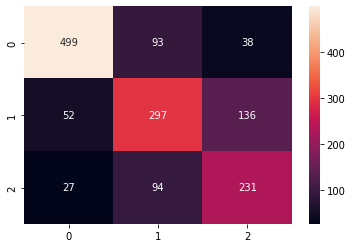

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

cm = confusion_matrix(y_valid_test, y_preds_test)

f = sns.heatmap(cm, annot=True, fmt='d')